## Calculation

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

def calculate_class_distribution(series):
    """Calculate class distribution for a series of classifications."""
    distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
    return distribution

def extract_task_from_filename(filename):
    """Extract task from filename string."""
    start = filename.find('_EN_') + len('_EN_')
    end = filename.find('_classify')
    return filename[start:end]

def color_rows_by_model(df):
    """Apply color coding to rows based on the values in the 'folder_path' column."""
    def row_color(row):
        if 'GPT35T' in row['folder_path']:
            return ['background-color: #ffebee'] * len(row)  # Light red
        elif 'MIXTRAL' in row['folder_path']:
            return ['background-color: #e8f5e9'] * len(row)  # Light green
        elif 'LLAMA3' in row['folder_path']:
            return ['background-color: #e3f2fd'] * len(row)  # Light blue
        else:
            return [''] * len(row)
    
    return df.style.apply(row_color, axis=1)

def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
    """Tries to open a file with multiple encodings and separators."""
    for encoding in encodings:
        sep = ';'
        try:
            df = pd.read_csv(file_path, sep=sep, encoding=encoding, on_bad_lines='warn')
            print(f"Attempting to read {file_path} with encoding '{encoding}' and separator '{sep}'")
            return df, encoding, sep
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            print(f"Error parsing file {file_path} with encoding '{encoding}' and separator '{sep}': {e}")
            continue
    raise UnicodeDecodeError(f"Unable to decode and parse file with available encodings and separators: {file_path}")

def load_predicted_dataframes(folder_path):
    """Load all CSV files from a folder and return a dictionary of DataFrames."""
    dataframes = {}
    for file_name in os.listdir(folder_path):
        full_file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {full_file_path}")
        if file_name.endswith('.csv'):
            try:
                df, used_encoding, used_separator = try_open_file(full_file_path)
                dataframes[file_name] = df
                print(f"Loaded {file_name} with encoding {used_encoding} and separator '{used_separator}'")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")
                print(f"Check the file: {full_file_path} for formatting issues.")
    return dataframes

def clean_dataframe(df, valid_classes):
    """Clean the DataFrame by replacing NaNs and invalid classes with 'none', and excluding 'none' classifications."""
    initial_rows = df.shape[0]
    
    if 'classification_cleaned' in df.columns:
        df['classification_cleaned'] = df['classification_cleaned'].astype(str)
        df['classification_cleaned'] = df['classification_cleaned'].apply(
            lambda x: x if x in valid_classes else 'none'
        )
        
        df = df[df['classification_cleaned'] != 'none']
        discarded_rows = initial_rows - df.shape[0]
    else:
        discarded_rows = initial_rows
    
    return df, discarded_rows

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    y_true = ground_truth_df['type_reply'].astype(str)
    results = []

    skipped_files = []
    common_index = y_true.index
    initial_row_count = len(y_true)
    invalid_rows_across_all_files = set()

    # New dictionary to keep track of invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                invalid_indices = df_pred.index[
                    df_pred['classification_cleaned'].isna() |
                    ~df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Track invalid rows for this specific file
                rows_not_used_due_to_file = len(invalid_indices)
                
                # Update the global set of invalid rows across all files
                invalid_rows_across_all_files.update(invalid_indices)
                
                # Update the model-specific set of invalid rows
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)
                
                # Filter out the invalid rows for the current file
                df_pred_clean = df_pred.drop(invalid_indices)
                
                # Update common index with the intersection of valid rows across files
                common_index = common_index.intersection(df_pred_clean.index)

                # Calculate metrics only for the valid, common rows
                df_pred_clean = df_pred_clean.loc[common_index]
                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                # Record used and not used row indices
                rows_used = common_index.tolist()
                rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

                metrics['rows_used'] = rows_used
                metrics['rows_not_used'] = rows_not_used
                metrics['rows_not_used_due_to_file'] = rows_not_used_due_to_file

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Calculate the total number of rows not used across all files
    count_rows_not_used_across_all_models = len(invalid_rows_across_all_files)

    # Calculate the total number of rows used across all models
    count_rows_used_across_all_models = initial_row_count - count_rows_not_used_across_all_models

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # # Plot and save the bar chart for each model
    # for model, invalid_rows in invalid_rows_by_model.items():
    #     plt.figure(figsize=(10, 6))
    #     plt.bar([model], [len(invalid_rows)], color='blue', alpha=0.7)
    #     plt.title(f'Total Rows Not Used by {model}')
    #     plt.ylabel('Count of Rows Not Used')
    #     plt.savefig(f'Evaluation_Plots/{model}_rows_not_used_with_GPT35T.pdf')
    #     plt.close()

    # Plot and save a combined bar chart for rows not used by each model
    plt.figure(figsize=(10, 6))
    models = ['LLAMA3', 'GPT35T', 'MIXTRAL']
    counts = [len(invalid_rows_by_model[model]) for model in models]
    plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
    
    # Add exact numbers above the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    # Adjust the upper limit of the y-axis to provide more space above the bars
    plt.ylim(0, max(counts) * 1.1)
    
    plt.title('Total Rows Not Used by Each Model')
    plt.ylabel('Count of Rows Not Used', fontsize=14)
    plt.savefig(fig_name)
    #plt.show()
    plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_csv(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


In [22]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

def calculate_class_distribution(series):
    """Calculate class distribution for a series of classifications."""
    distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
    return distribution

def extract_task_from_filename(filename):
    """Extract task from filename string."""
    start = filename.find('_EN_') + len('_EN_')
    end = filename.find('_classify')
    return filename[start:end]

def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
    """Tries to open a file with multiple encodings and separators."""
    for encoding in encodings:
        sep = ';'
        try:
            df = pd.read_csv(file_path, sep=sep, encoding=encoding, on_bad_lines='warn')
            print(f"Attempting to read {file_path} with encoding '{encoding}' and separator '{sep}'")
            return df, encoding, sep
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            print(f"Error parsing file {file_path} with encoding '{encoding}' and separator '{sep}': {e}")
            continue
    raise UnicodeDecodeError(f"Unable to decode and parse file with available encodings and separators: {file_path}")

def load_predicted_dataframes(folder_path):
    """Load all CSV files from a folder and return a dictionary of DataFrames."""
    dataframes = {}
    for file_name in os.listdir(folder_path):
        full_file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {full_file_path}")
        if file_name.endswith('.csv'):
            try:
                df, used_encoding, used_separator = try_open_file(full_file_path)
                dataframes[file_name] = df
                print(f"Loaded {file_name} with encoding {used_encoding} and separator '{used_separator}'")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")
                print(f"Check the file: {full_file_path} for formatting issues.")
    return dataframes

def clean_dataframe(df, valid_classes):
    """Clean the DataFrame by replacing NaNs and invalid classes with 'none', and excluding 'none' classifications."""
    initial_rows = df.shape[0]
    
    if 'classification_cleaned' in df.columns:
        df['classification_cleaned'] = df['classification_cleaned'].astype(str)
        df['classification_cleaned'] = df['classification_cleaned'].apply(
            lambda x: x if x in valid_classes else 'none'
        )
        
        df = df[df['classification_cleaned'] != 'none']
        discarded_rows = initial_rows - df.shape[0]
    else:
        discarded_rows = initial_rows
    
    return df, discarded_rows

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    y_true = ground_truth_df['type_reply'].astype(str)
    results = []

    skipped_files = []
    common_index = y_true.index
    initial_row_count = len(y_true)
    invalid_rows_across_all_files = set()

    # New dictionary to keep track of invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                invalid_indices = df_pred.index[
                    df_pred['classification_cleaned'].isna() |
                    ~df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Track invalid rows for this specific file
                rows_not_used_due_to_file = len(invalid_indices)
                
                # Update the global set of invalid rows across all files
                invalid_rows_across_all_files.update(invalid_indices)
                
                # Update the model-specific set of invalid rows
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)
                
                # Filter out the invalid rows for the current file
                df_pred_clean = df_pred.drop(invalid_indices)
                
                # Update common index with the intersection of valid rows across files
                common_index = common_index.intersection(df_pred_clean.index)

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # After determining the common index, process files again to calculate metrics only for valid rows
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
                continue
            try:
                # Filter the dataframe to include only the rows that are in common_index
                df_pred_clean = df_pred.loc[common_index]

                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Calculate the total number of rows not used across all files
    count_rows_not_used_across_all_models = len(invalid_rows_across_all_files)

    # Calculate the total number of rows used across all models
    count_rows_used_across_all_models = initial_row_count - count_rows_not_used_across_all_models

    metrics_df = pd.DataFrame(results)

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # Plot and save a combined bar chart for rows not used by each model
    plt.figure(figsize=(10, 6))
    models = ['LLAMA3', 'GPT35T', 'MIXTRAL']
    counts = [len(invalid_rows_by_model[model]) for model in models]
    plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
    
    # Add exact numbers above the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    # Adjust the upper limit of the y-axis to provide more space above the bars
    plt.ylim(0, max(counts) * 1.1)
    
    plt.title('Total rows not used by each model')
    plt.ylabel('Count of Rows Not Used')
    plt.savefig(fig_name)
    #plt.show()
    plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_csv(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


    

def color_rows_by_model(df):
    """Apply color coding to rows based on the values in the 'folder_path' column."""
    def row_color(row):
        if 'GPT35T' in row['folder_path']:
            return ['background-color: #ffebee'] * len(row)  # Light red
        elif 'MIXTRAL' in row['folder_path']:
            return ['background-color: #e8f5e9'] * len(row)  # Light green
        elif 'LLAMA3' in row['folder_path']:
            return ['background-color: #e3f2fd'] * len(row)  # Light blue
        else:
            return [''] * len(row)
    
    return df.style.apply(row_color, axis=1)





###################

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

def calculate_class_distribution(series):
    """Calculate class distribution for a series of classifications."""
    distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
    return distribution

def extract_task_from_filename(filename):
    """Extract task from filename string."""
    start = filename.find('_EN_') + len('_EN_')
    end = filename.find('_class')
    return filename[start:end]

def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
    """Tries to open a file with multiple encodings and separators."""
    for encoding in encodings:
        sep = ';'
        try:
            df = pd.read_csv(file_path, sep=sep, encoding=encoding, on_bad_lines='warn')
            print(f"Attempting to read {file_path} with encoding '{encoding}' and separator '{sep}'")
            return df, encoding, sep
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            print(f"Error parsing file {file_path} with encoding '{encoding}' and separator '{sep}': {e}")
            continue
    raise UnicodeDecodeError(f"Unable to decode and parse file with available encodings and separators: {file_path}")

def load_predicted_dataframes(folder_path):
    """Load all CSV files from a folder and return a dictionary of DataFrames."""
    dataframes = {}
    for file_name in os.listdir(folder_path):
        full_file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {full_file_path}")
        if file_name.endswith('.csv'):
            try:
                df, used_encoding, used_separator = try_open_file(full_file_path)
                dataframes[file_name] = df
                print(f"Loaded {file_name} with encoding {used_encoding} and separator '{used_separator}'")
            except Exception as e:
                print(f"Failed to load {file_name}: {e}")
                print(f"Check the file: {full_file_path} for formatting issues.")
    return dataframes

def clean_dataframe(df, valid_classes):
    """Clean the DataFrame by replacing NaNs and invalid classes with 'none', and excluding 'none' classifications."""
    initial_rows = df.shape[0]
    
    if 'classification_cleaned' in df.columns:
        df['classification_cleaned'] = df['classification_cleaned'].astype(str)
        df['classification_cleaned'] = df['classification_cleaned'].apply(
            lambda x: x if x in valid_classes else 'none'
        )
        
        df = df[df['classification_cleaned'] != 'none']
        discarded_rows = initial_rows - df.shape[0]
    else:
        discarded_rows = initial_rows
    
    return df, discarded_rows

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, filename=None):
    """Plot and save confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if filename:
        plt.savefig(filename)
    #plt.show()
    plt.close()

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    y_true = ground_truth_df['type_reply'].astype(str)
    results = []

    skipped_files = []
    common_index = y_true.index
    initial_row_count = len(y_true)
    invalid_rows_across_all_files = set()

    # New dictionary to keep track of invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    # List to store confusion matrix filenames
    cm_filenames = []

    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                invalid_indices = df_pred.index[
                    df_pred['classification_cleaned'].isna() |
                    ~df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Track invalid rows for this specific file
                rows_not_used_due_to_file = len(invalid_indices)
                
                # Update the global set of invalid rows across all files
                invalid_rows_across_all_files.update(invalid_indices)
                
                # Update the model-specific set of invalid rows
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)
                
                # Filter out the invalid rows for the current file
                df_pred_clean = df_pred.drop(invalid_indices)
                
                # Update common index with the intersection of valid rows across files
                common_index = common_index.intersection(df_pred_clean.index)

                # Generate confusion matrix filenames based on file names
                cm_filename = f"Evaluation_Plots/cm_{os.path.splitext(file_name)[0]}.pdf"
                cm_filenames.append(cm_filename)

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # After determining the common index, process files again to calculate metrics and confusion matrices only for valid rows
    cm_counter = 0
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
                continue
            try:
                # Filter the dataframe to include only the rows that are in common_index
                df_pred_clean = df_pred.loc[common_index]

                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                # Calculate and plot confusion matrix
                cm = confusion_matrix(y_true_common, y_pred, labels=valid_classes)
                plot_confusion_matrix(cm, classes=valid_classes, title=f'Confusion Matrix for {file_name}', filename=cm_filenames[cm_counter])
                cm_counter += 1

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Calculate the total number of rows not used across all files
    count_rows_not_used_across_all_models = len(invalid_rows_across_all_files)

    # Calculate the total number of rows used across all models
    count_rows_used_across_all_models = initial_row_count - count_rows_not_used_across_all_models

    metrics_df = pd.DataFrame(results)

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)


    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # # Plot and save the bar chart for each model
    # for model, invalid_rows in invalid_rows_by_model.items():
    #     plt.figure(figsize=(10, 6))
    #     plt.bar([model], [len(invalid_rows)], color='blue', alpha=0.7)
    #     plt.title(f'Total Rows Not Used by {model}')
    #     plt.ylabel('Count of Rows Not Used')
    #     plt.savefig(f'Evaluation_Plots/{model}_rows_not_used_with_GPT35T.pdf')
    #     plt.close()


##new 
    # # Plot and save a combined bar chart for rows not used by each model
    # plt.figure(figsize=(10, 6))
    # models = ['LLAMA3', 'GPT35T', 'MIXTRAL']
    # counts = [len(invalid_rows_by_model[model]) for model in models]
    # plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
    
    # # Add exact numbers above the bars
    # for i, count in enumerate(counts):
    #     plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    # # Adjust the upper limit of the y-axis to provide more space above the bars
    # plt.ylim(0, max(counts) * 1.1)
    
    # plt.title('Total Rows Not Used by Each Model')
    # plt.ylabel('Count of Rows Not Used')
    # plt.savefig(fig_name)
    # #plt.show()
    # plt.close()

###end new



    # Filter out models with no invalid rows
    models = []
    counts = []
    for model, invalid_rows in invalid_rows_by_model.items():
        if invalid_rows:  # Only add models with invalid rows
            models.append(model)
            counts.append(len(invalid_rows))
    
    # Plot and save a combined bar chart for rows not used by each model
    if models:  # Check if there are any models to plot
        plt.figure(figsize=(10, 6))
        plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'][:len(models)], alpha=0.7)
        
        # Add exact numbers above the bars
        for i, count in enumerate(counts):
            plt.text(i, count + 5, str(count), ha='center', fontsize=12)
        
        # Adjust the upper limit of the y-axis to provide more space above the bars
        plt.ylim(0, max(counts) * 1.1)
        
        plt.title('Total rows not used by each model')
        plt.ylabel('Count of Rows Not Used')
        plt.savefig(fig_name)
        plt.show()
        plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    #rows_used_df.to_csv(output_file, index=False)
    rows_used_df.to_excel(output_file, index=False)


    return metrics_df, summary_stats, count_rows_not_used_across_all_models, cm_filenames

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    y_true = ground_truth_df['type_reply'].astype(str)
    initial_row_count = len(y_true)
    
    results = []
    skipped_files = []
    valid_indices_all_models = set(y_true.index)  # Start with all indices being valid

    # Track invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    # List to store confusion matrix filenames
    cm_filenames = []

    # First pass to determine valid indices across all models
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                valid_indices = df_pred.index[
                    df_pred['classification_cleaned'].notna() &
                    df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Update the global set of valid indices
                valid_indices_all_models = valid_indices_all_models.intersection(valid_indices)
                
                # Track invalid rows for this specific file
                invalid_indices = set(df_pred.index) - set(valid_indices)
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)

                # Generate confusion matrix filenames based on file names
                cm_filename = f"Evaluation_Plots/cm_{os.path.splitext(file_name)[0]}.pdf"
                cm_filenames.append(cm_filename)

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Convert valid indices set to list for DataFrame operations
    common_index = list(valid_indices_all_models)
    
    # Recalculate counts of used and not used rows
    count_rows_used_across_all_models = len(common_index)
    count_rows_not_used_across_all_models = initial_row_count - count_rows_used_across_all_models

    # Second pass to calculate metrics and generate confusion matrices only for valid rows
    cm_counter = 0
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
                continue
            try:
                # Filter the dataframe to include only the rows that are in common_index
                df_pred_clean = df_pred.loc[common_index]

                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                # Calculate and plot confusion matrix
                cm = confusion_matrix(y_true_common, y_pred, labels=valid_classes)
                plot_confusion_matrix(cm, classes=valid_classes, title=f'Confusion Matrix for {file_name}', filename=cm_filenames[cm_counter])
                cm_counter += 1

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # Plot and save a combined bar chart for rows not used by each model
    if any(invalid_rows_by_model.values()):  # Check if there are any invalid rows to plot
        plt.figure(figsize=(10, 6))
        models = list(invalid_rows_by_model.keys())
        counts = [len(invalid_rows_by_model[model]) for model in models]
        plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
        
        # Add exact numbers above the bars
        for i, count in enumerate(counts):
            plt.text(i, count + 5, str(count), ha='center', fontsize=12)
        
        # Adjust the upper limit of the y-axis to provide more space above the bars
        plt.ylim(0, max(counts) * 1.1)
        
        plt.title('Total rows not used by each model')
        plt.ylabel('Count of Rows Not Used')
        plt.savefig(fig_name)
        plt.show()
        plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_excel(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models, cm_filenames

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


### With GPT35T

In [25]:
# # # List of folders for different models
# # predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# # valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# # ground_truth_file_with_gpt35t = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'
# # output_file = 'used_rows_for_evaluation_wo_GPT35T.csv'
# # fig_name = 'Evaluation_Plots/combined_rows_not_used_by_model_with_GPT35T.pdf'

# # metrics_df_with_gpt35t, summary_stats_with_gpt35t, total_discarded_rows = process_files(ground_truth_file_with_gpt35t, predicted_folders, valid_classes, output_file, fig_name)



# metrics_df_with_gpt35t, summary_stats_with_gpt35t, count_rows_not_used, cm_filenames = process_files(
#     ground_truth_file=r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx',
#     predicted_folders=[
#         r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', 
#         r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', 
#         r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct'
#     ],
#     valid_classes=['appropriate', 'inappropriate', 'offensive', 'violent'],
#     output_file='used_rows_for_evaluation_with_GPT35T.csv',
#     fig_name='Evaluation_Plots/combined_rows_not_used_by_model_with_GPT35T.pdf'
# )



# # Apply color coding to the metrics DataFrame
# styled_metrics_df_with_gpt35t = color_rows_by_model(metrics_df_with_gpt35t)

# # Apply color coding to the metrics DataFrame
# styled_summary_stats_df_with_gpt35t = color_rows_by_model(summary_stats_with_gpt35t)

# # Save the metrics DataFrame as an Excel file
# output_file = 'metrics_results_ALL_FINAL_with_GPT35T.xlsx'
# styled_metrics_df_with_gpt35t.to_excel(output_file, index=False)
# print(f"Metrics saved to {output_file}")

# # Save the summary statistics DataFrame as an Excel file
# summary_output_file_with_gpt35t = 'summary_stats_ALL_FINAL_with_GPT35T.xlsx'
# styled_summary_stats_df_with_gpt35t.to_excel(summary_output_file_with_gpt35t, index=False)
# print(f"Summary statistics saved to {summary_output_file_with_gpt35t}")


### Without GPT35T

## Visualisations

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

def darker_color(color, factor=0.8):
    """Darken the color by a given factor."""
    color_rgb = mcolors.to_rgb(color)
    return tuple([c * factor for c in color_rgb])

def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    paths = summary_stats_df['short_path'].unique()
    num_tasks = len(summary_stats_df['task'].unique())
    bar_width = 1.8  # Increase in bar width
    group_spacing = 0.5  # Less spacing between groups for compactness
    
    # Increase the figure size to accommodate larger bars and groups
    fig, axs = plt.subplots(2, 1, figsize=(30, 15), gridspec_kw={'hspace': 1.5})  # Increased hspace
    
    for ax, metric in zip(axs, metrics):
        x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
        # Extract the first task to set as baseline
        baseline_task = summary_stats_df['task'].unique()[0]
        baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
        # Draw horizontal lines for the baseline task in the background
        for i, (idx, row) in enumerate(baseline_data.iterrows()):
            baseline_value = row[f'{metric}_mean']
            color = color_code_for_path(row['short_path'])
            ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
        for i, short_path in enumerate(paths):
            path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
            y = path_metrics_df[f'{metric}_mean']
            yerr = path_metrics_df[f'{metric}_std']
            
            color = color_code_for_path(short_path)
            edge_color = darker_color(color)  # Adjust edge color automatically
            
            bars = ax.bar(x + i * bar_width, y, 
                          yerr=yerr, width=bar_width, label=short_path, 
                          color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
            # Place mean and std dev labels above the error bars
            for j in range(len(y)):
                ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
                        f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
                        ha='center', fontsize=18, color='black', alpha=0.9, zorder=3)
        
        ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=28)
        ax.set_ylabel(f'{metric.capitalize()}', fontsize=23)
        
        # Modify the task names to include line breaks where needed and add "Task XY:" in bold
        tasks = summary_stats_df['task'].unique()
        formatted_tasks = []
        for i, task in enumerate(tasks):
            formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
            
            # Add a space between "Task" and the number
            formatted_tasks.append(f"$\\bf{{Task\ {i+1}:}}$ {formatted_task}")

        # Set the modified tasks as xtick labels
        ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
        ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=16)
        ax.tick_params(axis='x', labelsize=23)
        ax.tick_params(axis='y', labelsize=23)
        
        # Adding lighter gridlines
        ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Adjust y-limit to provide space at the top
        ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
        # Place the legend in the bottom right corner with a white, slightly transparent background
        legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])

    # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
    plt.savefig(f"{name_fig}", bbox_inches='tight')
    
    plt.show()


In [27]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# def extract_relevant_path(folder_path):
#     if "LLAMA3" in folder_path:
#         return "LLAMA3"
#     elif "GPT35T" in folder_path:
#         return "GPT35T"
#     elif "MIXTRAL" in folder_path:
#         return "MIXTRAL"
#     return folder_path

# def color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#FF6F61'  # Coral
#     elif 'MIXTRAL' in path:
#         return '#6BAED6'  # Medium Blue
#     elif 'LLAMA' in path:
#         return '#74C476'  # Light Green
#     else:
#         return '#ffffff'  # White

# def darker_color(color, factor=0.8):
#     """Darken the color by a given factor."""
#     color_rgb = mcolors.to_rgb(color)
#     return tuple([c * factor for c in color_rgb])

# def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
#     # Define the metrics to analyze
#     metrics = ['accuracy', 'f1_macro']
    
#     # Extract relevant paths
#     summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
#     paths = summary_stats_df['short_path'].unique()
#     num_tasks = len(summary_stats_df['task'].unique())
#     bar_width = 1.8  # Increase in bar width
#     group_spacing = 0.5  # Less spacing between groups for compactness
    
#     # Increase the figure size to accommodate larger bars and groups
#     fig, axs = plt.subplots(2, 1, figsize=(40, 25), gridspec_kw={'hspace': 1})
    
#     for ax, metric in zip(axs, metrics):
#         x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
#         for i, short_path in enumerate(paths):
#             path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
#             y = path_metrics_df[f'{metric}_mean']
#             yerr = path_metrics_df[f'{metric}_std']
            
#             color = color_code_for_path(short_path)
#             edge_color = darker_color(color)  # Adjust edge color automatically
            
#             ax.bar(x + i * bar_width, y, 
#                    yerr=yerr, width=bar_width, label=short_path, 
#                    color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5)
            
#             # Place mean and std dev labels above the error bars
#             for j in range(len(y)):
#                 ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
#                         f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
#                         ha='center', fontsize=18, color='black', alpha=0.9)
        
#         ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=28)
#         ax.set_ylabel(f'{metric.capitalize()}', fontsize=23)
        
#         # Modify the task names to include line breaks where needed
#         tasks = summary_stats_df['task'].unique()
#         formatted_tasks = [task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript') for task in tasks]

#         # Set the modified tasks as xtick labels
#         ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
#         ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=16)
#         ax.tick_params(axis='x', labelsize=23)
#         ax.tick_params(axis='y', labelsize=23)
        
#         # Adding lighter gridlines
#         ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
#         # Adjust y-limit to provide space at the top
#         ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
#         # Place the legend inside the plot, in the upper left corner
#         ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=18, frameon=False)
    
#     plt.tight_layout(rect=[0, 0, 0.85, 0.95])
#     plt.savefig(name_fig)
#     plt.show()


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def analyze_and_plot_heatmap(metrics_df, summary_stats_df, fig_name):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    # Add "Task XY:" to the task names by grouping and transforming
    summary_stats_df['task_with_number'] = summary_stats_df.groupby('task').ngroup() + 1
    summary_stats_df['task_with_number'] = summary_stats_df['task_with_number'].apply(lambda x: f"$\\bf{{Task {x}:}}$") + ' ' + summary_stats_df['task']
    
    # Replace the original task with the new one including the task number
    summary_stats_df['task'] = summary_stats_df['task_with_number']
    
    # Ensure the task order matches the order in the bar charts
    task_order = summary_stats_df['task'].unique()
    summary_stats_df['task'] = pd.Categorical(summary_stats_df['task'], categories=task_order, ordered=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 9), gridspec_kw={'wspace': 0.1})
    
    for ax, metric in zip(axs, metrics):
        # Pivot the data for the heatmap using the new task_with_number column
        pivot_df = summary_stats_df.pivot(index='task', columns='short_path', values=f'{metric}_mean')
        
        # Plot heatmap with increased legend title size
        sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=.5, 
                    cbar_kws={'label': f'{metric.capitalize()}', 'fontsize': 20}, ax=ax, annot_kws={"size": 16})
        
        ax.set_title(f'{metric.capitalize()} by Task and Model', fontsize=20)
        ax.set_xlabel('Model', fontsize=18)
        
        # Only display the task name once
        if metric == 'accuracy':
            ax.set_ylabel('Task', fontsize=16)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=18)
        ax.tick_params(axis='y', labelsize=18)
        
        # Adjust the aspect ratio
        ax.set_aspect(aspect='auto')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()


In [29]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors

# def extract_relevant_path(folder_path):
#     if "LLAMA3" in folder_path:
#         return "LLAMA3"
#     elif "GPT35T" in folder_path:
#         return "GPT35T"
#     elif "MIXTRAL" in folder_path:
#         return "MIXTRAL"
#     return folder_path

# def color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#FF6F61'  # Coral
#     elif 'MIXTRAL' in path:
#         return '#6BAED6'  # Medium Blue
#     elif 'LLAMA' in path:
#         return '#74C476'  # Light Green
#     else:
#         return '#ffffff'  # White

# def darker_color(color, factor=0.8):
#     """Darken the color by a given factor."""
#     color_rgb = mcolors.to_rgb(color)
#     return tuple([c * factor for c in color_rgb])

# def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
#     # Define the metrics to analyze
#     metrics = ['accuracy', 'f1_macro']
    
#     # Extract relevant paths
#     summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
#     paths = summary_stats_df['short_path'].unique()
#     num_tasks = len(summary_stats_df['task'].unique())
#     bar_width = 1.8  # Increase in bar width
#     group_spacing = 0.5  # Less spacing between groups for compactness
    
#     # Increase the figure size to accommodate larger bars and groups
#     fig, axs = plt.subplots(2, 1, figsize=(40, 25), gridspec_kw={'hspace': 1.5})  # Increased hspace
    
#     for ax, metric in zip(axs, metrics):
#         x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
#         # Extract the first task to set as baseline
#         baseline_task = summary_stats_df['task'].unique()[0]
#         baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
#         # Draw horizontal lines for the baseline task in the background
#         for i, (idx, row) in enumerate(baseline_data.iterrows()):
#             baseline_value = row[f'{metric}_mean']
#             color = color_code_for_path(row['short_path'])
#             ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
#         for i, short_path in enumerate(paths):
#             path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
#             y = path_metrics_df[f'{metric}_mean']
#             yerr = path_metrics_df[f'{metric}_std']
            
#             color = color_code_for_path(short_path)
#             edge_color = darker_color(color)  # Adjust edge color automatically
            
#             bars = ax.bar(x + i * bar_width, y, 
#                           yerr=yerr, width=bar_width, label=short_path, 
#                           color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
#             # Place mean and std dev labels above the error bars
#             for j in range(len(y)):
#                 ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
#                         f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
#                         ha='center', fontsize=18, color='black', alpha=0.9, zorder=3)
        
#         ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=28)
#         ax.set_ylabel(f'{metric.capitalize()}', fontsize=23)
        
#         # Modify the task names to include line breaks where needed and add "Task XY:" in bold
#         tasks = summary_stats_df['task'].unique()
#         formatted_tasks = []
#         for i, task in enumerate(tasks):
#             formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
#             formatted_tasks.append(f"$\\bf{{Task {i+1}:}}$ {formatted_task}")

#         # Set the modified tasks as xtick labels
#         ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
#         ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=16)
#         ax.tick_params(axis='x', labelsize=23)
#         ax.tick_params(axis='y', labelsize=23)
        
#         # Adding lighter gridlines
#         ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
#         # Adjust y-limit to provide space at the top
#         ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
#         # Place the legend in the bottom right corner with a white, slightly transparent background
#         legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
#         legend.get_frame().set_facecolor('white')
#         legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
#     plt.tight_layout(rect=[0, 0, 0.85, 0.95])

#     # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
#     #plt.savefig(f"{name_fig}.png", bbox_inches='tight')
#     plt.savefig(f"{name_fig}", bbox_inches='tight')
    
#     plt.show()


In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

def darker_color(color, factor=0.8):
    """Darken the color by a given factor."""
    color_rgb = mcolors.to_rgb(color)
    return tuple([c * factor for c in color_rgb])

# def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
#     # Define the metrics to analyze
#     metrics = ['accuracy', 'f1_macro']
    
#     # Extract relevant paths
#     summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
#     paths = summary_stats_df['short_path'].unique()
#     num_tasks = len(summary_stats_df['task'].unique())
#     bar_width = 1.8  # Increase in bar width
#     group_spacing = 0.5  # Less spacing between groups for compactness
    
#     # Increase the figure size to accommodate larger bars and groups
#     fig, axs = plt.subplots(2, 1, figsize=(40, 30), gridspec_kw={'hspace': 2})  # Increased hspace
    
#     for ax, metric in zip(axs, metrics):
#         x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
#         # Extract the first task to set as baseline
#         baseline_task = summary_stats_df['task'].unique()[0]
#         baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
#         # Draw horizontal lines for the baseline task in the background
#         for i, (idx, row) in enumerate(baseline_data.iterrows()):
#             baseline_value = row[f'{metric}_mean']
#             color = color_code_for_path(row['short_path'])
#             ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
#         for i, short_path in enumerate(paths):
#             path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
#             y = path_metrics_df[f'{metric}_mean']
#             yerr = path_metrics_df[f'{metric}_std']
            
#             color = color_code_for_path(short_path)
#             edge_color = darker_color(color)  # Adjust edge color automatically
            
#             bars = ax.bar(x + i * bar_width, y, 
#                           yerr=yerr, width=bar_width, label=short_path, 
#                           color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
#             # Place mean and std dev labels above the error bars
#             for j in range(len(y)):
#                 ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
#                         f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
#                         ha='center', fontsize=18, color='black', alpha=0.9, zorder=3)
        
#         ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=35)
#         ax.set_ylabel(f'{metric.capitalize()}', fontsize=30)
        
#         # Modify the task names to include line breaks where needed and add "Task XY:" in bold
#         tasks = summary_stats_df['task'].unique()
#         formatted_tasks = []
#         for i, task in enumerate(tasks):
#             #formatted_task = task.replace('_descriptionYT_transcript', '_descriptionYT\n_transcript')
#             formatted_task = task.replace('description_descriptionYT', '_description\n_descriptionYT')
#             # Add a space between "Task" and the number
#             formatted_tasks.append(f"$\\bf{{Task\ {i+1}:}}$ {formatted_task}")

#         # Set the modified tasks as xtick labels
#         ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
#         ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=16)
#         ax.tick_params(axis='x', labelsize=28)
#         ax.tick_params(axis='y', labelsize=28)
        
#         # Adding lighter gridlines
#         ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
#         # Adjust y-limit to provide space at the top
#         ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
#         # Place the legend in the bottom right corner with a white, slightly transparent background
#         legend = ax.legend(loc='lower right', fontsize=18, frameon=True)
#         legend.get_frame().set_facecolor('white')
#         legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
#     plt.tight_layout(rect=[0, 0, 0.95, 0.95])

#     # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
#     plt.savefig(f"{name_fig}", bbox_inches='tight')
    
#     plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "Llama-3"
    elif "GPT35T" in folder_path:
        return "GPT-3.5-Turbo"
    elif "MIXTRAL" in folder_path:
        return "Mixtral"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path or 'GPT-3.5-Turbo' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path or 'Mixtral' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path or 'Llama-3' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

def darker_color(color, factor=0.8):
    """Darken the color by a given factor."""
    color_rgb = mcolors.to_rgb(color)
    return tuple([c * factor for c in color_rgb])

def analyze_and_plot(metrics_df, summary_stats_df, name_fig):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    paths = summary_stats_df['short_path'].unique()
    num_tasks = len(summary_stats_df['task'].unique())
    bar_width = 3#1.8  # Increase in bar width
    group_spacing = 0.5  # Less spacing between groups for compactness
    
    # Increase the figure size to accommodate larger bars and groups
    fig, axs = plt.subplots(2, 1, figsize=(50, 35), gridspec_kw={'hspace': 2})  # Increased hspace
    
    for ax, metric in zip(axs, metrics):
        x = np.arange(num_tasks) * (len(paths) * bar_width + group_spacing)  # Adjust label locations for wider bars
        
        # Extract the first task to set as baseline
        baseline_task = summary_stats_df['task'].unique()[0]
        baseline_data = summary_stats_df[summary_stats_df['task'] == baseline_task]
        
        # Draw horizontal lines for the baseline task in the background
        for i, (idx, row) in enumerate(baseline_data.iterrows()):
            baseline_value = row[f'{metric}_mean']
            color = color_code_for_path(row['short_path'])
            ax.axhline(y=baseline_value, color=color, linestyle='--', linewidth=2, alpha=0.8, zorder=0)
        
        for i, short_path in enumerate(paths):
            path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
            y = path_metrics_df[f'{metric}_mean']
            yerr = path_metrics_df[f'{metric}_std']
            
            color = color_code_for_path(short_path)
            edge_color = darker_color(color)  # Adjust edge color automatically
            
            bars = ax.bar(x + i * bar_width, y, 
                          yerr=yerr, width=bar_width, label=short_path, 
                          color=color, capsize=5, alpha=0.8, edgecolor=edge_color, linewidth=1.5, zorder=2)
            
            # Place mean and std dev labels above the error bars
            for j in range(len(y)):
                ax.text(x[j] + i * bar_width, y.iloc[j] + yerr.iloc[j] + 0.02, 
                        f'{y.iloc[j]:.2f}\n±{yerr.iloc[j]:.2f}', 
                        ha='center', fontsize=20, color='black', alpha=0.9, zorder=3)
        
        ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=40)
        ax.set_ylabel(f'{metric.capitalize()}', fontsize=35)
        ax.set_xlabel('Task', fontsize=35)  # Added x-axis label with increased font size
        
        # Modify the task names to include line breaks where needed and add "Task XY:" in bold
        tasks = summary_stats_df['task'].unique()
        formatted_tasks = []
        for i, task in enumerate(tasks):
            formatted_task = task.replace('description_descriptionYT', '_description\n_descriptionYT')
            formatted_tasks.append(f"$\\bf{{Task\ {i+1}:}}$ {formatted_task}")

        # Set the modified tasks as xtick labels
        ax.set_xticks(x + bar_width * (len(paths) - 1) / 2)
        ax.set_xticklabels(formatted_tasks, rotation=45, ha='right', fontsize=28)
        ax.tick_params(axis='x', labelsize=40)
        ax.tick_params(axis='y', labelsize=40)
        
        # Adding lighter gridlines
        ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Adjust y-limit to provide space at the top
        ax.set_ylim(0, max(y + yerr) + 0.1)  # Add some padding to the top
    
        # Place the legend in the bottom right corner with a white, slightly transparent background
        legend = ax.legend(loc='lower right', fontsize=25, frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)  # Slight transparency for the legend background
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])

    # Save the plot as both PNG and PDF with bbox_inches='tight' to avoid cutting off labels
    plt.savefig(f"{name_fig}", bbox_inches='tight')
    
    plt.show()

# Example usage:
# analyze_and_plot(metrics_df, summary_stats_df, "combined_metrics_plot")


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def analyze_and_plot_heatmap(metrics_df, summary_stats_df, fig_name):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    # Add "Task XY: " to the task names by grouping and transforming
    summary_stats_df['task_with_number'] = summary_stats_df.groupby('task').ngroup() + 1
    summary_stats_df['task_with_number'] = summary_stats_df['task_with_number'].apply(lambda x: f"$\\bf{{Task\ {x}:}}$") + ' ' + summary_stats_df['task']
    
    # Replace the original task with the new one including the task number
    summary_stats_df['task'] = summary_stats_df['task_with_number']
    
    # Ensure the task order matches the order in the bar charts
    task_order = summary_stats_df['task'].unique()
    summary_stats_df['task'] = pd.Categorical(summary_stats_df['task'], categories=task_order, ordered=True)
    
    # Create subplots to place both heatmaps in one figure
    fig, axs = plt.subplots(2, 1, figsize=(16, 18))  # Two rows, one column
    
    for ax, metric in zip(axs, metrics):
        # Pivot the data for the heatmap using the new task_with_number column
        pivot_df = summary_stats_df.pivot(index='task', columns='short_path', values=f'{metric}_mean')
        
        # Plot heatmap with adjusted text sizes
        heatmap = sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=.5, 
                              cbar_kws={'label': f'{metric.capitalize()}'}, annot_kws={"size": 14}, ax=ax)
        
        # Set the title of the colorbar with increased font size
        colorbar = heatmap.collections[0].colorbar
        colorbar.ax.set_ylabel(f'{metric.capitalize()}', fontsize=16)
        
        # Increase the font size of the colorbar tick labels
        colorbar.ax.tick_params(labelsize=12)
        
        ax.set_title(f'{metric.capitalize()} by Task and Model', fontsize=18)
        ax.set_xlabel('Model', fontsize=14)
        
        # Adjust the y-axis label sizes
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=14)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
        
        # Adjust the aspect ratio
        ax.set_aspect('auto')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"{fig_name}", bbox_inches='tight')

    plt.show()

# Example usage:
# analyze_and_plot_heatmap(metrics_df, summary_stats_df, "combined_heatmap")


In [101]:
# import pandas as pd
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
#     ground_truth_df = load_ground_truth(ground_truth_file)
    
#     # Mapping for new class names
#     class_mapping = {
#         "0. appropriate": "appropriate",
#         "1. inappropriate": "inappropriate",
#         "2. offensive": "offensive",
#         "3. violent": "violent"
#     }

#     ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
#     y_true = ground_truth_df['type_reply'].astype(str)
#     initial_row_count = len(y_true)
    
#     results = []
#     skipped_files = []
#     valid_indices_all_models = set(y_true.index)  # Start with all indices being valid

#     # Track invalid rows per model
#     invalid_rows_by_model = {
#         'LLAMA3': set(),
#         'GPT35T': set(),
#         'MIXTRAL': set()
#     }

#     # List to store confusion matrix filenames
#     cm_filenames = []

#     # First pass to determine valid indices across all models
#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
        
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' not in df_pred.columns:
#                 skipped_files.append(file_name)
#                 continue
            
#             try:
#                 df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
#                 valid_indices = df_pred.index[
#                     df_pred['classification_cleaned'].notna() &
#                     df_pred['classification_cleaned'].isin(valid_classes)
#                 ]
                
#                 # Update the global set of valid indices
#                 valid_indices_all_models = valid_indices_all_models.intersection(valid_indices)
                
#                 # Track invalid rows for this specific file
#                 invalid_indices = set(df_pred.index) - set(valid_indices)
#                 if 'LLAMA3' in folder_path:
#                     invalid_rows_by_model['LLAMA3'].update(invalid_indices)
#                 elif 'GPT35T' in folder_path:
#                     invalid_rows_by_model['GPT35T'].update(invalid_indices)
#                 elif 'MIXTRAL' in folder_path:
#                     invalid_rows_by_model['MIXTRAL'].update(invalid_indices)

#                 # Generate confusion matrix filenames based on file names
#                 cm_filename = f"Evaluation_Plots/cm_{os.path.splitext(file_name)[0]}.pdf"
#                 cm_filenames.append(cm_filename)

#             except Exception as e:
#                 print(f"Failed to process {file_name}: {e}")
#                 skipped_files.append(file_name)

#     # Convert valid indices set to list for DataFrame operations
#     common_index = list(valid_indices_all_models)
    
#     # Recalculate counts of used and not used rows
#     count_rows_used_across_all_models = len(common_index)
#     count_rows_not_used_across_all_models = initial_row_count - count_rows_used_across_all_models

#     # Second pass to calculate metrics and generate confusion matrices only for valid rows
#     cm_counter = 0
#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
#                 continue
#             try:
#                 # Filter the dataframe to include only the rows that are in common_index
#                 df_pred_clean = df_pred.loc[common_index]

#                 y_pred = df_pred_clean['classification_cleaned']
#                 y_true_common = y_true.loc[common_index]

#                 metrics = calculate_metrics(y_true_common, y_pred)
#                 metrics['file_name'] = file_name
#                 metrics['folder_path'] = folder_path

#                 # Extract task from filename
#                 metrics['task'] = extract_task_from_filename(file_name)

#                 # Calculate class distributions
#                 ground_truth_distribution = calculate_class_distribution(y_true_common)
#                 predicted_distribution = calculate_class_distribution(y_pred)
#                 metrics['ground_truth_distribution'] = str(ground_truth_distribution)
#                 metrics['predicted_distribution'] = str(predicted_distribution)

#                 # Calculate and plot confusion matrix
#                 cm = confusion_matrix(y_true_common, y_pred, labels=valid_classes)
#                 plot_confusion_matrix(cm, classes=valid_classes, title=f'Confusion Matrix for {file_name}', filename=cm_filenames[cm_counter])
#                 cm_counter += 1

#                 results.append(metrics)
#             except Exception as e:
#                 print(f"Failed to process {file_name}: {e}")
#                 skipped_files.append(file_name)

#     # Add the counts of not used rows by model to the results and calculate the used rows
#     for result in results:
#         if 'LLAMA3' in result['folder_path']:
#             result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
#         elif 'GPT35T' in result['folder_path']:
#             result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
#         elif 'MIXTRAL' in result['folder_path']:
#             result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
#         result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
#         result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
#         result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

#     metrics_df = pd.DataFrame(results)

#     if skipped_files:
#         print("\nSkipped files:")
#         for file_name in skipped_files:
#             print(file_name)

#     # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
#     grouped = metrics_df.groupby(['folder_path', 'task'])

#     summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
#     summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
#     for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
#         metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
#         metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
#         metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

#     # Create the directory for saving plots if it doesn't exist
#     os.makedirs('Evaluation_Plots', exist_ok=True)

#     # Plot and save a combined bar chart for rows not used by each model
#     if any(invalid_rows_by_model.values()):  # Check if there are any invalid rows to plot
#         plt.figure(figsize=(10, 6))
#         models = list(invalid_rows_by_model.keys())
#         counts = [len(invalid_rows_by_model[model]) for model in models]
#         plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
        
#         # Add exact numbers above the bars
#         for i, count in enumerate(counts):
#             plt.text(i, count + 5, str(count), ha='center', fontsize=12)
        
#         # Adjust the upper limit of the y-axis to provide more space above the bars
#         plt.ylim(0, max(counts) * 1.1)
        
#         plt.title('Total Rows Not Used by Each Model')
#         plt.ylabel('Count of Rows Not Used')
#         plt.savefig(fig_name)
#         plt.show()
#         plt.close()

#     # Export the rows used for evaluation to a CSV file
#     rows_used_df = ground_truth_df.loc[common_index]
#     rows_used_df.to_excel(output_file, index=False)

#     return metrics_df, summary_stats, count_rows_not_used_across_all_models, cm_filenames

# def load_ground_truth(file_path):
#     """Load the ground truth data from an Excel file."""
#     return pd.read_excel(file_path)


In [102]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def process_files(ground_truth_file, predicted_folders, valid_classes, output_file, fig_name):
    ground_truth_df = load_ground_truth(ground_truth_file)
    
    # Mapping for new class names
    class_mapping = {
        "0. appropriate": "appropriate",
        "1. inappropriate": "inappropriate",
        "2. offensive": "offensive",
        "3. violent": "violent"
    }

    # Apply mapping and filter out 'none' values
    ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    ground_truth_df = ground_truth_df[ground_truth_df['type_reply'] != 'none']  # Remove 'none' values
    
    y_true = ground_truth_df['type_reply'].astype(str)
    initial_row_count = len(y_true)
    
    results = []
    skipped_files = []
    valid_indices_all_models = set(y_true.index)  # Start with all indices being valid

    # Track invalid rows per model
    invalid_rows_by_model = {
        'LLAMA3': set(),
        'GPT35T': set(),
        'MIXTRAL': set()
    }

    # List to store confusion matrix filenames
    cm_filenames = []

    # First pass to determine valid indices across all models
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns:
                skipped_files.append(file_name)
                continue
            
            try:
                df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
                valid_indices = df_pred.index[
                    df_pred['classification_cleaned'].notna() &
                    df_pred['classification_cleaned'].isin(valid_classes)
                ]
                
                # Update the global set of valid indices
                valid_indices_all_models = valid_indices_all_models.intersection(valid_indices)
                
                # Track invalid rows for this specific file
                invalid_indices = set(df_pred.index) - set(valid_indices)
                if 'LLAMA3' in folder_path:
                    invalid_rows_by_model['LLAMA3'].update(invalid_indices)
                elif 'GPT35T' in folder_path:
                    invalid_rows_by_model['GPT35T'].update(invalid_indices)
                elif 'MIXTRAL' in folder_path:
                    invalid_rows_by_model['MIXTRAL'].update(invalid_indices)

                # Generate confusion matrix filenames based on file names
                cm_filename = f"Evaluation_Plots/cm_{os.path.splitext(file_name)[0]}.pdf"
                cm_filenames.append(cm_filename)

            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Convert valid indices set to list for DataFrame operations
    common_index = list(valid_indices_all_models)
    
    # Recalculate counts of used and not used rows
    count_rows_used_across_all_models = len(common_index)
    count_rows_not_used_across_all_models = initial_row_count - count_rows_used_across_all_models

    # Second pass to calculate metrics and generate confusion matrices only for valid rows
    cm_counter = 0
    for folder_path in predicted_folders:
        predicted_dfs = load_predicted_dataframes(folder_path)
        for file_name, df_pred in predicted_dfs.items():
            if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
                continue
            try:
                # Filter the dataframe to include only the rows that are in common_index
                df_pred_clean = df_pred.loc[common_index]

                y_pred = df_pred_clean['classification_cleaned']
                y_true_common = y_true.loc[common_index]

                metrics = calculate_metrics(y_true_common, y_pred)
                metrics['file_name'] = file_name
                metrics['folder_path'] = folder_path

                # Extract task from filename
                metrics['task'] = extract_task_from_filename(file_name)

                # Calculate class distributions
                ground_truth_distribution = calculate_class_distribution(y_true_common)
                predicted_distribution = calculate_class_distribution(y_pred)
                metrics['ground_truth_distribution'] = str(ground_truth_distribution)
                metrics['predicted_distribution'] = str(predicted_distribution)

                # Calculate and plot confusion matrix
                cm = confusion_matrix(y_true_common, y_pred, labels=valid_classes)
                plot_confusion_matrix(cm, classes=valid_classes, title=f'Confusion Matrix for {file_name}', filename=cm_filenames[cm_counter])
                cm_counter += 1

                results.append(metrics)
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")
                skipped_files.append(file_name)

    # Add the counts of not used rows by model to the results and calculate the used rows
    for result in results:
        if 'LLAMA3' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['LLAMA3'])
        elif 'GPT35T' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['GPT35T'])
        elif 'MIXTRAL' in result['folder_path']:
            result['count_rows_not_used'] = len(invalid_rows_by_model['MIXTRAL'])
        
        result['count_rows_used'] = initial_row_count - result['count_rows_not_used']
        result['count_rows_not_used_across_all_models'] = count_rows_not_used_across_all_models
        result['count_rows_used_across_all_models'] = count_rows_used_across_all_models

    metrics_df = pd.DataFrame(results)

    if skipped_files:
        print("\nSkipped files:")
        for file_name in skipped_files:
            print(file_name)

    # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
    grouped = metrics_df.groupby(['folder_path', 'task'])

    summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
    summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
        metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
        metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

    # Create the directory for saving plots if it doesn't exist
    os.makedirs('Evaluation_Plots', exist_ok=True)

    # Plot and save a combined bar chart for rows not used by each model
    if any(invalid_rows_by_model.values()):  # Check if there are any invalid rows to plot
        plt.figure(figsize=(10, 6))
        models = list(invalid_rows_by_model.keys())
        counts = [len(invalid_rows_by_model[model]) for model in models]
        plt.bar(models, counts, color=['#74C476', '#FF6F61', '#6BAED6'], alpha=0.7)
        
        # Add exact numbers above the bars
        for i, count in enumerate(counts):
            plt.text(i, count + 5, str(count), ha='center', fontsize=16)
        
        # Adjust the upper limit of the y-axis to provide more space above the bars
        plt.ylim(0, max(counts) * 1.1)
        plt.xticks(fontsize=16) 
        plt.title('Total rows not used by each model', fontsize=20)
        plt.ylabel('Count of rows not used', fontsize=16)
        plt.savefig(fig_name)
        plt.show()
        plt.close()

    # Export the rows used for evaluation to a CSV file
    rows_used_df = ground_truth_df.loc[common_index]
    rows_used_df.to_excel(output_file, index=False)

    return metrics_df, summary_stats, count_rows_not_used_across_all_models, cm_filenames

def load_ground_truth(file_path):
    """Load the ground truth data from an Excel file."""
    return pd.read_excel(file_path)


In [103]:
def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "Llama-3"
    elif "GPT35T" in folder_path:
        return "GPT-3.5-Turbo"
    elif "MIXTRAL" in folder_path:
        return "Mixtral"
    return folder_path

def color_code_for_path(path):
    if 'GPT35T' in path or 'GPT-3.5-Turbo' in path:
        return '#FF6F61'  # Coral
    elif 'MIXTRAL' in path or 'Mixtral' in path:
        return '#6BAED6'  # Medium Blue
    elif 'LLAMA' in path or 'Llama-3' in path:
        return '#74C476'  # Light Green
    else:
        return '#ffffff'  # White

### With GPT35T

Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\further_exp
Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL.csv
Attempting to read ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL_SECOND.csv
Attempting to read ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL_SECOND.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL_SECOND.csv with encoding utf-8 and separator ';'
Processing file: ./l

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\old
Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here.csv
Attempting to read ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here_new_THIRD-new21.csv
Attempting to read ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here_new_THIRD-new21.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Processing file: ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_GPT35T_Hatebase_FINAL_2.csv
Attempting to read ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_GPT35T_Hatebase_FINAL_2.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_GPT35T_Hatebase_FINAL_2.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_GPT35T_Hatebase_FINAL_ABSOL.csv
Attempting to read ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_GPT35T_Hatebase_FINAL_ABSOL.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_GPT35T_Hatebase_FINAL_ABSOL.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_GPT35T_Ha

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

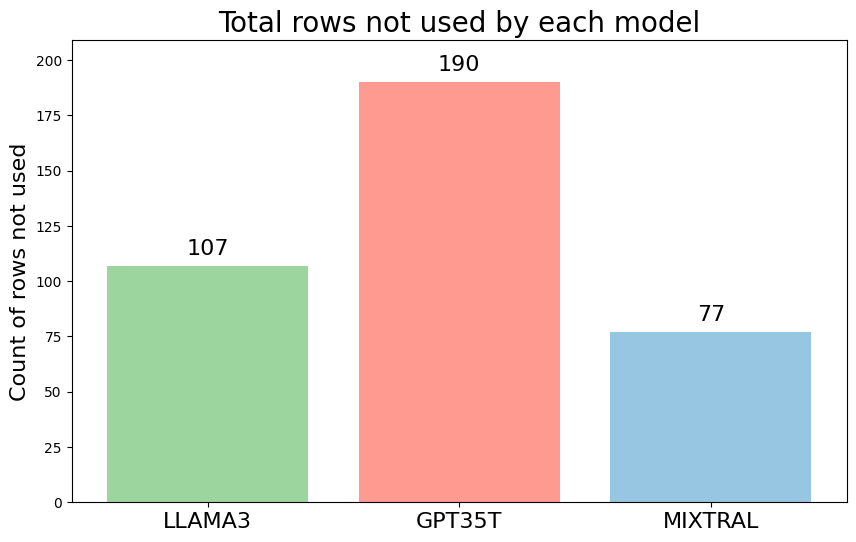

Metrics saved to metrics_results_ALL_FINAL_with_GPT35T.xlsx
Summary statistics saved to summary_stats_ALL_FINAL_with_GPT35T.xlsx


In [104]:
# # List of folders for different models
# predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# ground_truth_file_with_gpt35t = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'
# output_file = 'used_rows_for_evaluation_wo_GPT35T.csv'
# fig_name = 'Evaluation_Plots/combined_rows_not_used_by_model_with_GPT35T.pdf'

# metrics_df_with_gpt35t, summary_stats_with_gpt35t, total_discarded_rows = process_files(ground_truth_file_with_gpt35t, predicted_folders, valid_classes, output_file, fig_name)



metrics_df_with_gpt35t, summary_stats_with_gpt35t, count_rows_not_used, cm_filenames = process_files(
    ground_truth_file=r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx',
    predicted_folders=[
        r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', 
        r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', 
        r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct'
    ],
    valid_classes=['appropriate', 'inappropriate', 'offensive', 'violent'],
    output_file='used_rows_for_evaluation_with_GPT35T.xlsx',
    fig_name='Evaluation_Plots_comp/combined_rows_not_used_by_model_with_GPT35T.pdf'
)



# Apply color coding to the metrics DataFrame
styled_metrics_df_with_gpt35t = color_rows_by_model(metrics_df_with_gpt35t)

# Apply color coding to the metrics DataFrame
styled_summary_stats_df_with_gpt35t = color_rows_by_model(summary_stats_with_gpt35t)

# Save the metrics DataFrame as an Excel file
output_file = 'metrics_results_ALL_FINAL_with_GPT35T.xlsx'
styled_metrics_df_with_gpt35t.to_excel(output_file, index=False)
print(f"Metrics saved to {output_file}")

# Save the summary statistics DataFrame as an Excel file
summary_output_file_with_gpt35t = 'summary_stats_ALL_FINAL_with_GPT35T.xlsx'
styled_summary_stats_df_with_gpt35t.to_excel(summary_output_file_with_gpt35t, index=False)
print(f"Summary statistics saved to {summary_output_file_with_gpt35t}")


C:\Users\aboeck\AppData\Local\Temp\ipykernel_31144\3190163693.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


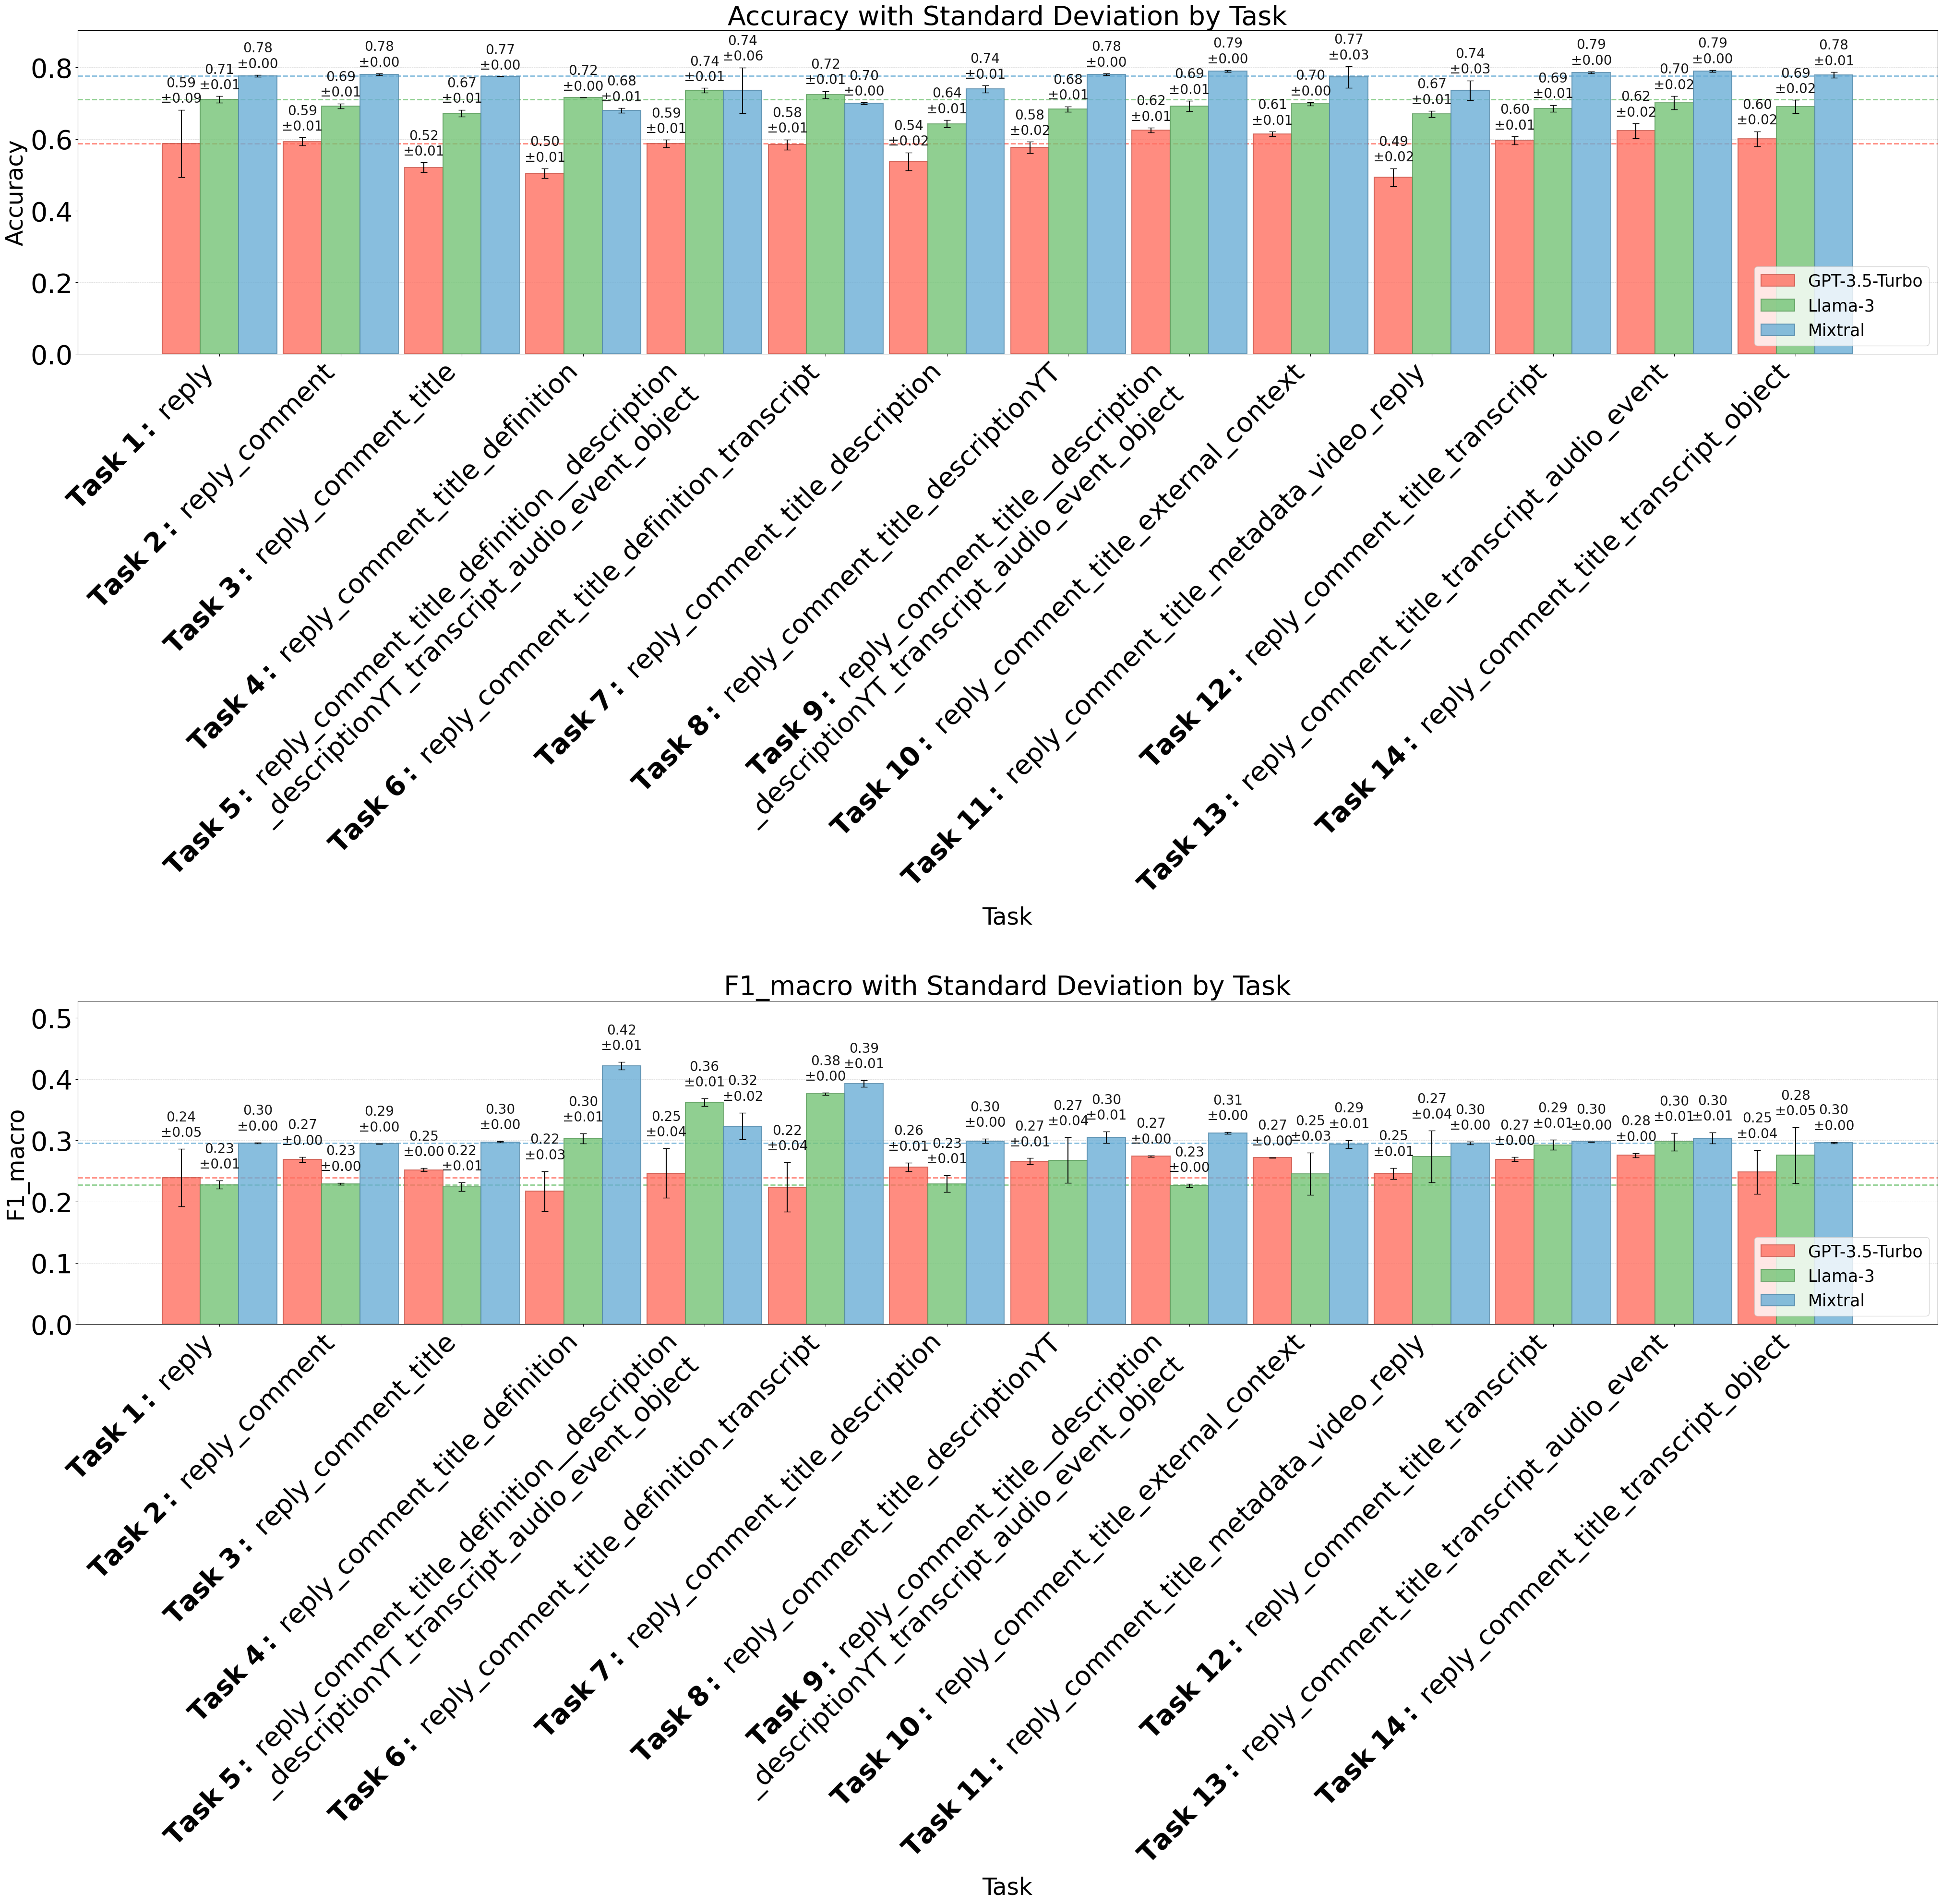

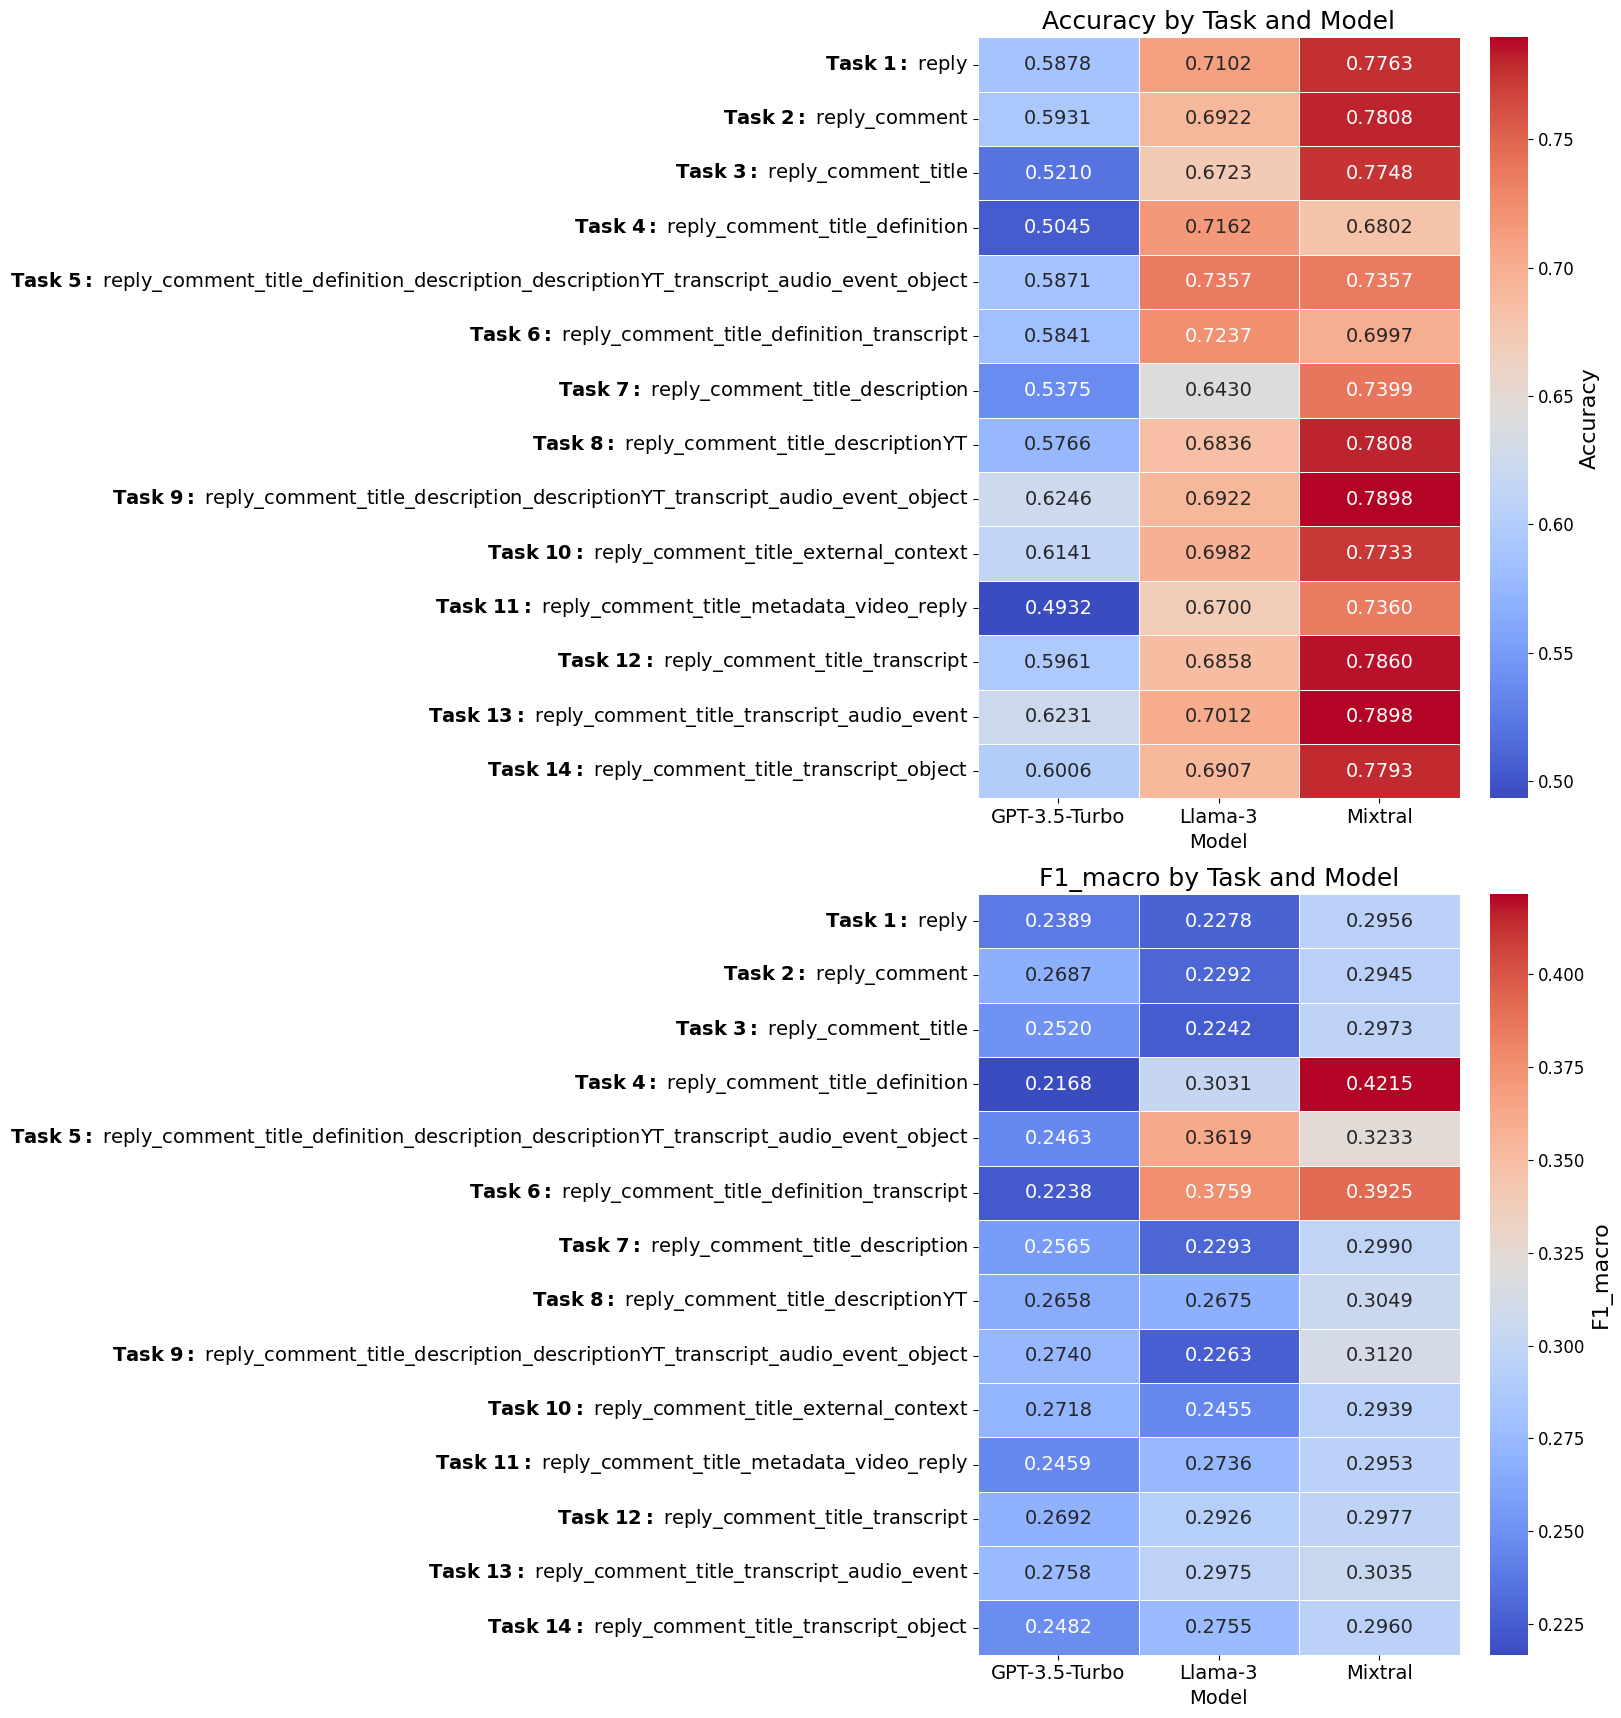

In [105]:
name_fig = f'Evaluation_Plots_comp/combined_metrics_barchart_by_task_and_model_NEW_517_with_GPT35T.pdf'
name_fig_heatmap = f'Evaluation_Plots_comp/combined_metrics_heatmap_by_task_and_model_NEW_517_with_GPT35T.pdf'
analyze_and_plot(metrics_df_with_gpt35t, summary_stats_with_gpt35t, name_fig)
analyze_and_plot_heatmap(metrics_df_with_gpt35t, summary_stats_with_gpt35t, name_fig_heatmap)

In [106]:
#summary_stats_with_gpt35t

In [107]:
metrics_df_with_gpt35t

accuracy  precision_macro  recall_macro  f1_macro  precision_weighted  \
0    0.774775         0.276973      0.316759  0.295533            0.677460   
1    0.779279         0.277244      0.318600  0.296487            0.678123   
2    0.774775         0.275641      0.316759  0.294773            0.674203   
3    0.779279         0.273302      0.318600  0.294218            0.668481   
4    0.779279         0.273302      0.318600  0.294218            0.668481   
..        ...              ...           ...       ...                 ...   
136  0.585586         0.298851      0.239411  0.265849            0.730972   
137  0.594595         0.301370      0.243094  0.269113            0.737134   
138  0.576577         0.300469      0.235727  0.264190            0.734932   
139  0.612613         0.300221      0.250460  0.273092            0.734324   
140  0.612613         0.231293      0.187845  0.207317            0.754305   

     recall_weighted  f1_weighted  \
0           0.774775     0.722857   
1           0.779279     0.725190   
2           0.774775     0.720999   
3           0.779279     0.719641   
4           0.779279     0.719641   
..               ...          ...   
136         0.585586     0.650251   
137         0.594595     0.658236   
138         0.576577     0.646194   
139         0.612613     0.667969   
140         0.612613     0.676115   

                                             file_name  \
0    _EN_reply_classify_replies_561_MIXTRAL_Hatebas...   
1    _EN_reply_classify_replies_561_MIXTRAL_Hatebas...   
2    _EN_reply_classify_replies_561_MIXTRAL_Hatebas...   
3    _EN_reply_comment_classify_replies_561_MIXTRAL...   
4    _EN_reply_comment_classify_replies_561_MIXTRAL...   
..                                                 ...   
136  _EN_reply_comment_title_transcript_classify_re...   
137  _EN_reply_comment_title_transcript_classify_re...   
138  _EN_reply_comment_title_transcript_object_clas...   
139  _EN_reply_comment_title_transcript_object_clas...   
140  _EN_reply_comment_title_transcript_object_clas...   

                                           folder_path  \
0    ./log_files/MIXTRAL/csv_from_log_files/manuall...   
1    ./log_files/MIXTRAL/csv_from_log_files/manuall...   
2    ./log_files/MIXTRAL/csv_from_log_files/manuall...   
3    ./log_files/MIXTRAL/csv_from_log_files/manuall...   
4    ./log_files/MIXTRAL/csv_from_log_files/manuall...   
..                                                 ...   
136  ./log_files/GPT35T/csv_from_log_files/manually...   
137  ./log_files/GPT35T/csv_from_log_files/manually...   
138  ./log_files/GPT35T/csv_from_log_files/manually...   
139  ./log_files/GPT35T/csv_from_log_files/manually...   
140  ./log_files/GPT35T/csv_from_log_files/manually...   

                                      task  ... f1_macro_std  \
0                                    reply  ...     0.000859   
1                                    reply  ...     0.000859   
2                                    reply  ...     0.000859   
3                            reply_comment  ...     0.000547   
4                            reply_comment  ...     0.000547   
..                                     ...  ...          ...   
136         reply_comment_title_transcript  ...     0.003441   
137         reply_comment_title_transcript  ...     0.003441   
138  reply_comment_title_transcript_object  ...     0.035684   
139  reply_comment_title_transcript_object  ...     0.035684   
140  reply_comment_title_transcript_object  ...     0.035684   

    precision_weighted_mean  precision_weighted_median  \
0                  0.676595                   0.677460   
1                  0.676595                   0.677460   
2                  0.676595                   0.677460   
3                  0.668712                   0.668481   
4                  0.668712                   0.668481   
..                      ...                        ...   
136                0.735605                   0.737134

### Without GPT35T

Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\further_exp
Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL.csv
Attempting to read ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL_SECOND.csv
Attempting to read ./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL_SECOND.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_MIXTRAL_Hatebase_FINAL_SECOND.csv with encoding utf-8 and separator ';'
Processing file: ./l

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\old
Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here.csv
Attempting to read ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here.csv with encoding utf-8 and separator ';'
Processing file: ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here_new_THIRD-new21.csv
Attempting to read ./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct\_EN_reply_classify_replies_561_LLAMA3_Hatebase_FINAL_AAAAAAAABSOLUTE_here_new_THIRD-new21.csv with encoding 'utf-8' and separator ';'
Loaded _EN_reply_classify

c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aboeck\AppData\Local\anaconda3\envs\new_MA\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

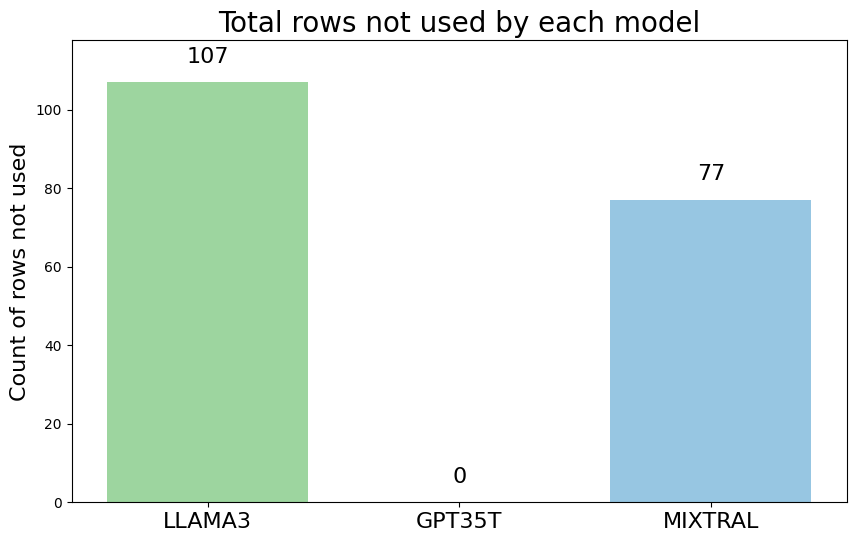

Metrics saved to metrics_results_ALL_FINAL_without_GPT35T.xlsx
Summary statistics saved to summary_stats_ALL_FINAL_without_GPT35T.xlsx


In [108]:
# # List of folders for different models
# predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct'] # r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# ground_truth_file_without_gpt35t = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'
# output_file = 'used_rows_for_evaluation_wo_GPT35T.csv'
# fig_name = 'Evaluation_Plots/combined_rows_not_used_by_model_without_GPT35T.pdf'

# metrics_df_without_gpt35t, summary_stats_without_gpt35t, total_discarded_rows = process_files(ground_truth_file_without_gpt35t, predicted_folders, valid_classes, output_file, fig_name)



metrics_df_without_gpt35t, summary_stats_without_gpt35t, count_rows_not_used, cm_filenames = process_files(
    ground_truth_file=r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx',
    predicted_folders=[
        r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', 
        r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', 
        # r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct'
    ],
    valid_classes=['appropriate', 'inappropriate', 'offensive', 'violent'],
    output_file='used_rows_for_evaluation_without_GPT35T.xlsx',
    fig_name='Evaluation_Plots/combined_rows_not_used_by_model_without_GPT35T.pdf'
)

# Apply color coding to the metrics DataFrame
styled_metrics_df_without_gpt35t = color_rows_by_model(metrics_df_without_gpt35t)

# Apply color coding to the metrics DataFrame
styled_summary_stats_df_without_gpt35t = color_rows_by_model(summary_stats_without_gpt35t)

# Save the metrics DataFrame as an Excel file
output_file = 'metrics_results_ALL_FINAL_without_GPT35T.xlsx'
styled_metrics_df_without_gpt35t.to_excel(output_file, index=False)
print(f"Metrics saved to {output_file}")

# Save the summary statistics DataFrame as an Excel file
summary_output_file_without_gpt35t = 'summary_stats_ALL_FINAL_without_GPT35T.xlsx'
styled_summary_stats_df_without_gpt35t.to_excel(summary_output_file_without_gpt35t, index=False)
print(f"Summary statistics saved to {summary_output_file_without_gpt35t}")


C:\Users\aboeck\AppData\Local\Temp\ipykernel_31144\3190163693.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


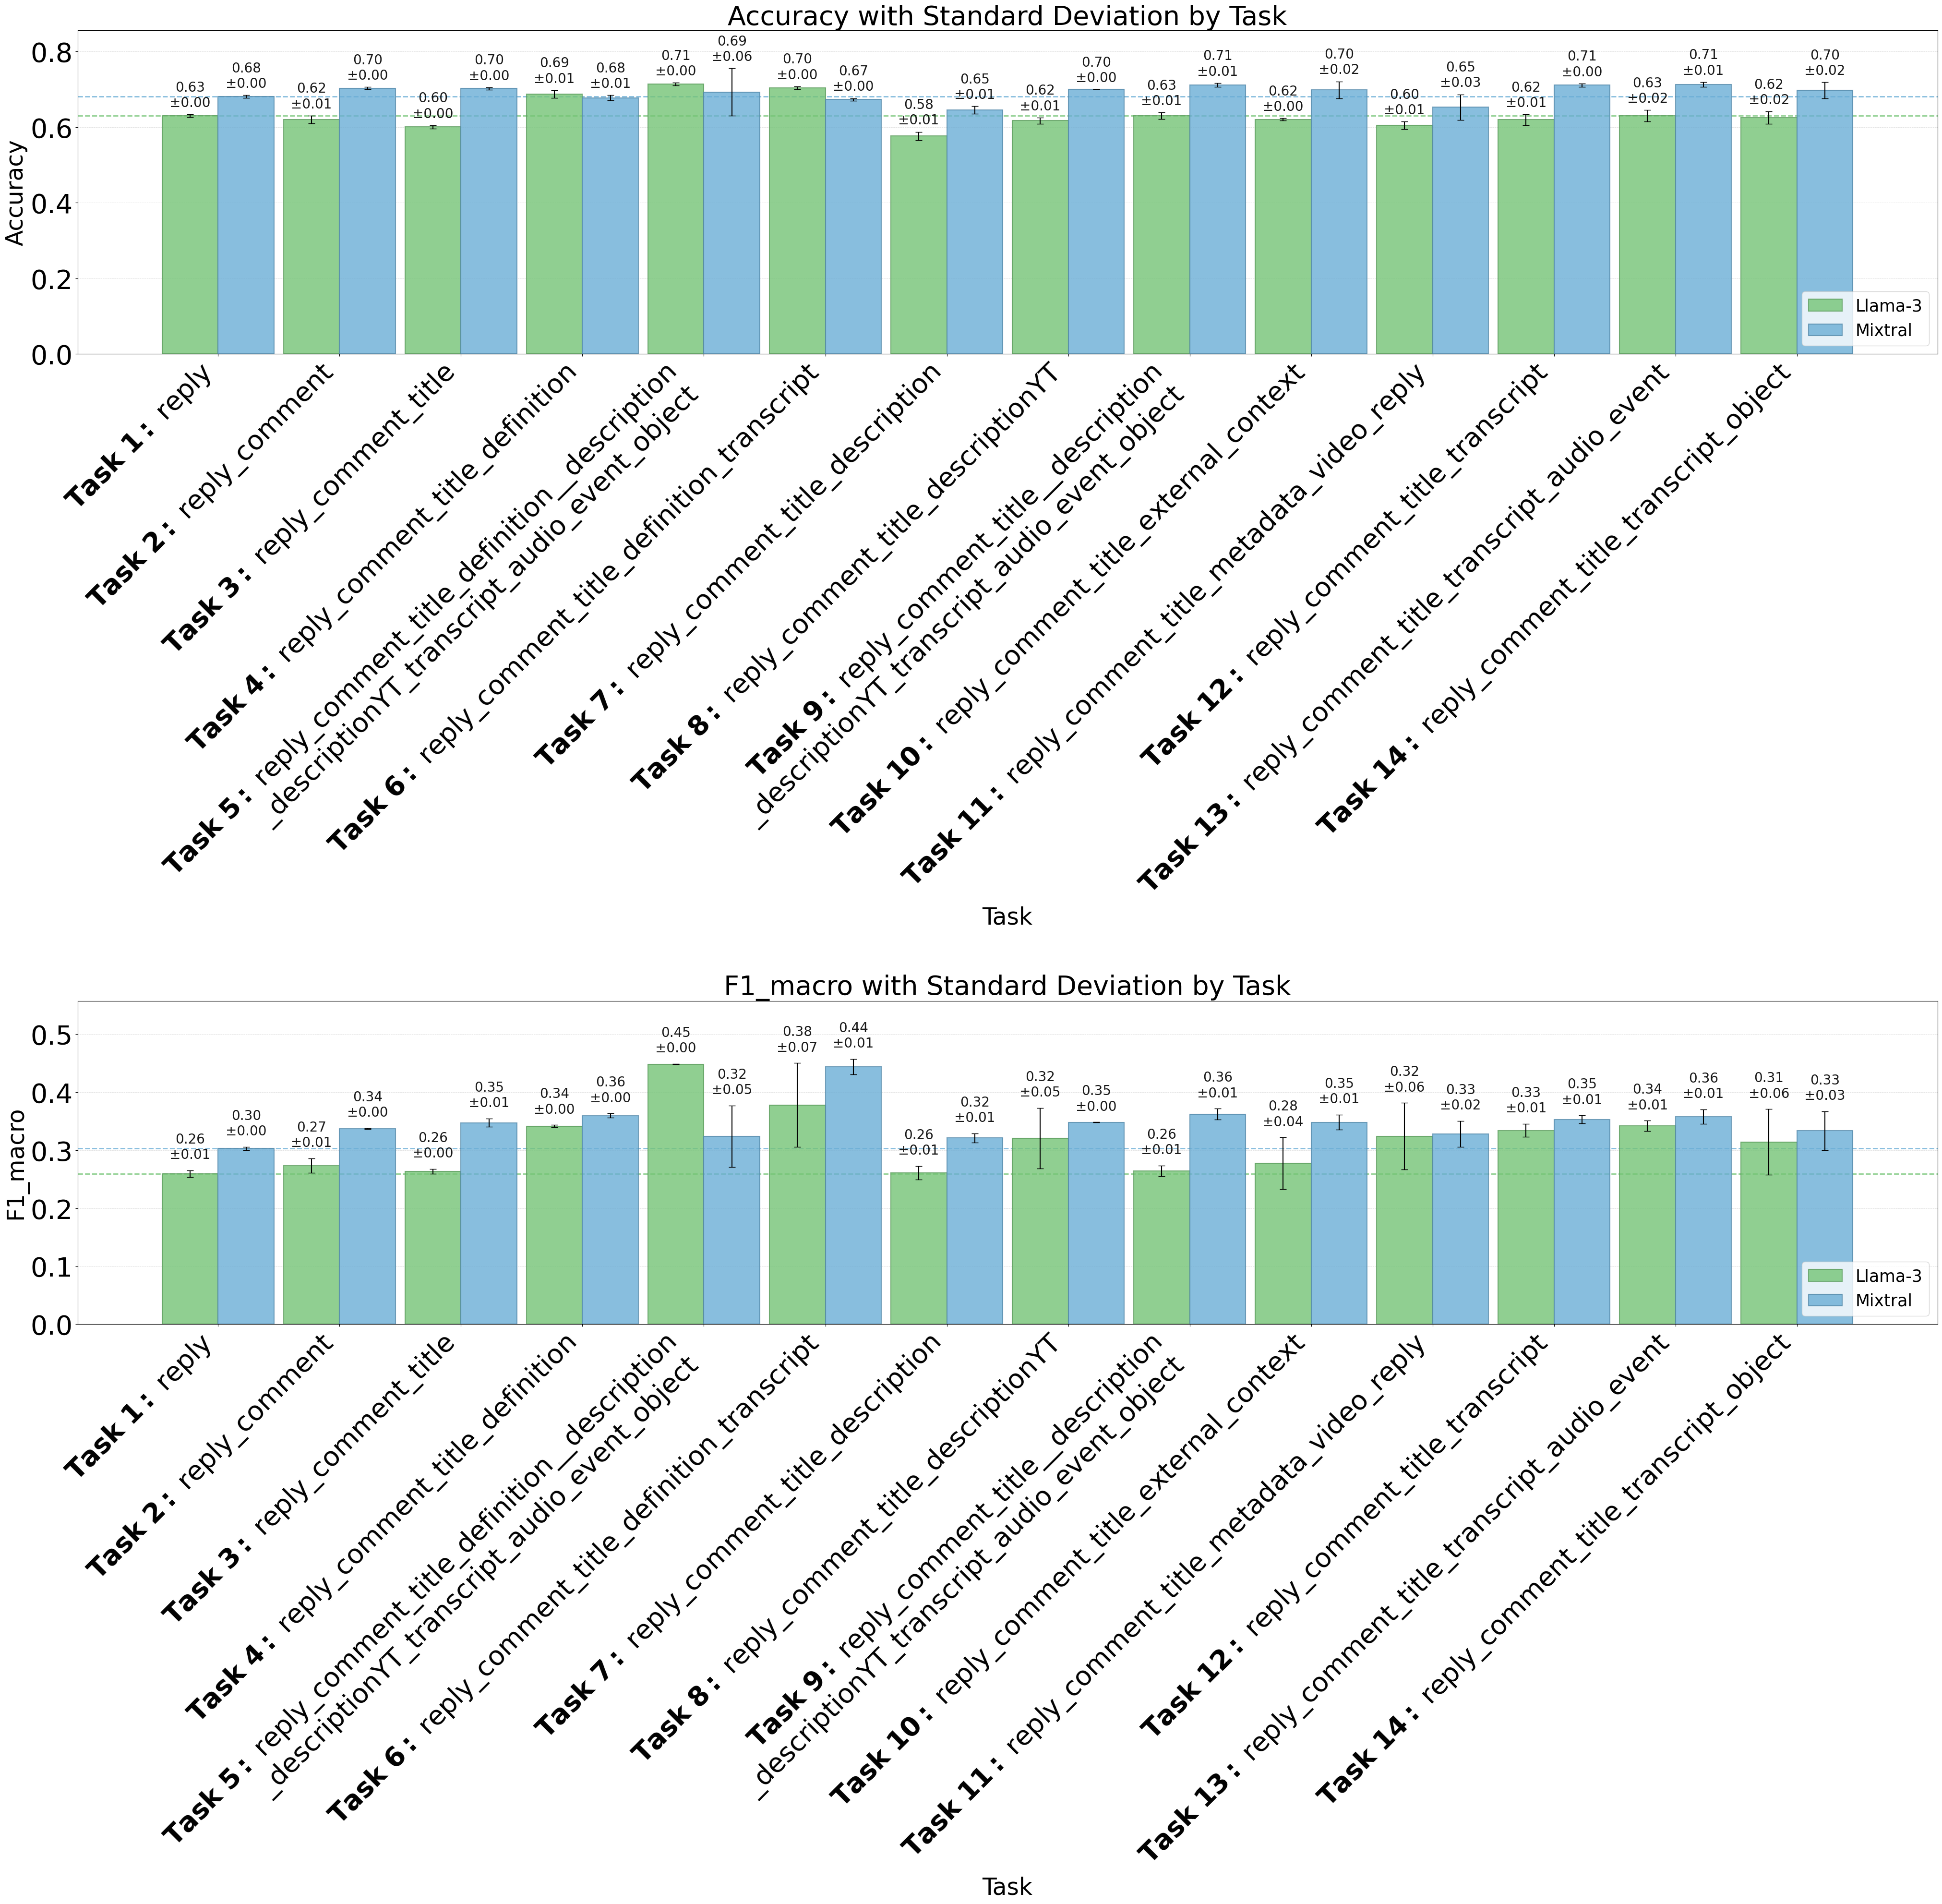

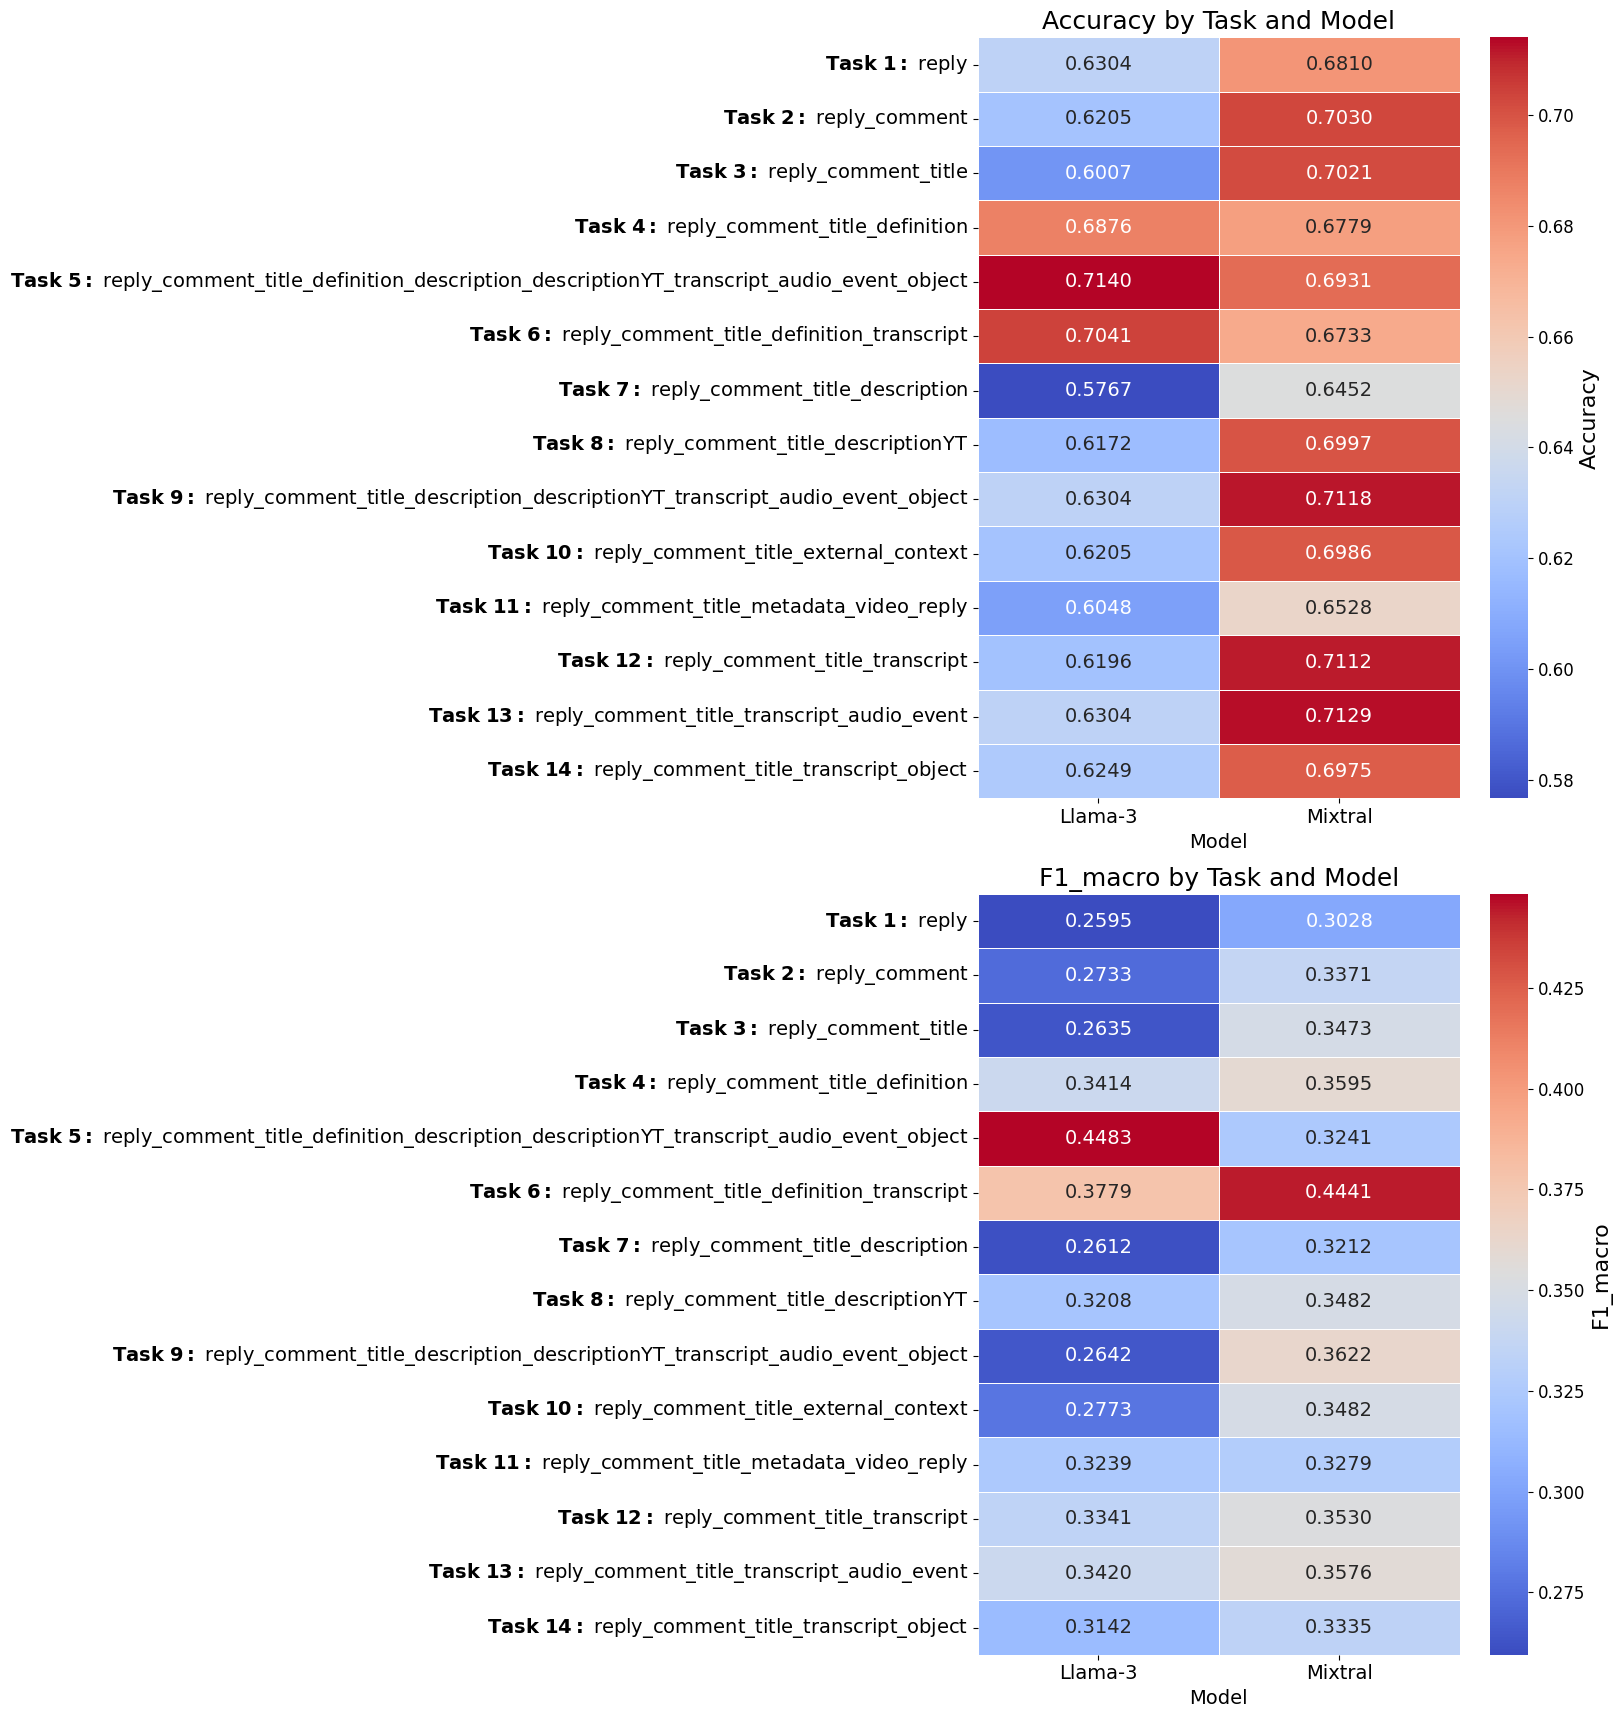

In [109]:
name_fig = f'Evaluation_Plots_comp/combined_metrics_barchart_by_task_and_model_NEW_517_without_GPT35T.pdf'
name_fig_heatmap = f'Evaluation_Plots_comp/combined_metrics_heatmap_by_task_and_model_NEW_517_without_GPT35T.pdf'
analyze_and_plot(metrics_df_without_gpt35t, summary_stats_without_gpt35t, name_fig)
analyze_and_plot_heatmap(metrics_df_without_gpt35t, summary_stats_without_gpt35t, name_fig_heatmap)

In [ ]:


# # Example dataframes (replace these with actual data)
# # metrics_df = pd.read_csv('metrics.csv')
# # summary_stats_df = pd.read_csv('summary_stats.csv')

# # Call the function to analyze and plot the data
# name_fig=(f'Evaluation_Plots/combined_metrics_with_std_by_task_NEW_517.pdf')
# analyze_and_plot(metrics_df, summary_stats, name_fig)


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# def extract_relevant_path(folder_path):
#     if "LLAMA3" in folder_path:
#         return "LLAMA3"
#     elif "GPT35T" in folder_path:
#         return "GPT35T"
#     elif "MIXTRAL" in folder_path:
#         return "MIXTRAL"
#     return folder_path

# def color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#d81b60'  # Dark Rose
#     elif 'MIXTRAL' in path:
#         return '#388e3c'  # Dark Green
#     elif 'LLAMA' in path:
#         return '#1976d2'  # Dark Blue
#     else:
#         return '#ffffff'  # White

# def line_color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#ff8a8a'  # Light Rose
#     elif 'MIXTRAL' in path:
#         return '#81c784'  # Light Green
#     elif 'LLAMA' in path:
#         return '#90caf9'  # Light Blue
#     else:
#         return '#d3d3d3'  # Light Grey

# def analyze_and_plot(metrics_df, summary_stats_df):
#     # Define the metrics to analyze
#     metrics = ['accuracy', 'f1_macro']
    
#     # Extract relevant paths
#     summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
#     paths = summary_stats_df['short_path'].unique()
    
#     # Find the global min and max values for the metrics
#     global_min = 0.15 #min(summary_stats_df['accuracy_mean'].min(), summary_stats_df['f1_macro_mean'].min())
#     global_max = 0.85 #max(summary_stats_df['accuracy_mean'].max(), summary_stats_df['f1_macro_mean'].max())
    
#     fig, axs = plt.subplots(2, 1, figsize=(14, 19), gridspec_kw={'hspace': 0.1})
    
#     for ax, metric in zip(axs, metrics):
#         for i, short_path in enumerate(paths):
#             path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
#             x = np.arange(len(path_metrics_df['task'])) + i * 0.2  # Slight offset for each model
#             y = path_metrics_df[f'{metric}_mean']
#             yerr = path_metrics_df[f'{metric}_std']
            
#             ax.errorbar(x, y, 
#                         yerr=yerr, fmt='o', label=short_path, 
#                         color=color_code_for_path(short_path), capsize=5)
#             ax.plot(x, y, color=line_color_code_for_path(short_path), linewidth=0.5)
            
#             # Add text labels for the mean values
#             for j in range(len(x)):
#                 ax.text(x[j] + 0.3, y.iloc[j] + 0.003, f'{y.iloc[j]:.2f}', 
#                         ha='center', fontsize=15, color='black', alpha=0.6,
#                         bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', pad=1))
        
#         ax.set_ylim(global_min, global_max)  # Set the same y-axis limits for both plots
#         ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=20)
#         ax.legend(fontsize=18)
#         ax.set_ylabel(f'{metric.capitalize()}', fontsize=18)
        
#         if metric == 'accuracy':
#             ax.set_xticklabels([])
#         else:
#             ax.set_xlabel('Task', fontsize=18)
#             ax.set_xticks(np.arange(len(path_metrics_df['task'])) + 0.1)
#             ax.set_xticklabels(path_metrics_df['task'], rotation=35, ha='right', fontsize=16)
#         ax.tick_params(axis='y', labelsize=16)
    
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.savefig(f'Evaluation_Plots/combined_metrics_with_std_by_task_min_max_NEW.pdf', bbox_inches='tight')
#     plt.show()

# # Example dataframes (replace these with actual data)
# # metrics_df = pd.read_csv('metrics.csv')
# # summary_stats_df = pd.read_csv('summary_stats.csv')

# # Call the function to analyze and plot the data
# analyze_and_plot(metrics_df, summary_stats_df)



In [ ]:

# Example dataframes (replace these with actual data)
# metrics_df = pd.read_csv('metrics.csv')
# summary_stats_df = pd.read_csv('summary_stats.csv')

# Call the function to analyze and plot the data



In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_relevant_path(folder_path):
    if "LLAMA3" in folder_path:
        return "LLAMA3"
    elif "GPT35T" in folder_path:
        return "GPT35T"
    elif "MIXTRAL" in folder_path:
        return "MIXTRAL"
    return folder_path

def analyze_and_plot(metrics_df, summary_stats_df):
    # Define the metrics to analyze
    metrics = ['accuracy', 'f1_macro']
    
    # Extract relevant paths
    summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 9), gridspec_kw={'width_ratios': [10, 10], 'wspace': 0.1})
    cbar_ax = fig.add_axes([.92, .15, .02, .7])  # Add an axis for the color bar
    
    for ax, metric in zip(axs, metrics):
        # Pivot the data for the heatmap
        pivot_df = summary_stats_df.pivot(index='task', columns='short_path', values=f'{metric}_mean')
        
        # Plot heatmap
        sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=.5, 
                    vmin=0, vmax=1, cbar=ax==axs[0], cbar_ax=cbar_ax if ax==axs[0] else None, 
                    cbar_kws={'label': 'Score'} if ax==axs[0] else None, annot_kws={"size": 16}, ax=ax)
        
        ax.set_title(f'{metric.capitalize()} by Task and Model', fontsize=20)
        ax.set_xlabel('Model', fontsize=18)
        
        # Only display the task name once
        if metric == 'accuracy':
            ax.set_ylabel('Task', fontsize=18)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right', fontsize=18)
        ax.tick_params(axis='y', labelsize=18)
        
        # Adjust the aspect ratio
        ax.set_aspect(aspect='auto')
    
    # Set font size of color bar label and ticks
    cbar = fig.colorbar(axs[0].collections[0], cbar_ax, label='Score')
    cbar.ax.yaxis.label.set_size(18)
    cbar.ax.tick_params(labelsize=18)
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Adjust layout to make room for color bar
    plt.savefig(f'Evaluation_Plots/combined_metrics_heatmap_by_task_and_model.pdf', bbox_inches='tight')
    plt.show()

# Example dataframes (replace these with actual data)
# metrics_df = pd.read_csv('metrics.csv')
# summary_stats_df = pd.read_csv('summary_stats.csv')

# Call the function to analyze and plot the data#
#analyze_and_plot(metrics_df, summary_stats_df)


In [27]:
# # import pandas as pd
# # import numpy as np
# # import os
# # from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# # import chardet

# # def detect_file_encoding(file_path):
# #     """Detects the encoding of a file."""
# #     with open(file_path, 'rb') as f:
# #         raw_data = f.read(10000)  # Read a sample of the file
# #     result = chardet.detect(raw_data)
# #     return result['encoding']

# # def load_ground_truth(file_path):
# #     """Load the ground truth data from an Excel file."""
# #     return pd.read_excel(file_path)

# # def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
# #     """Tries to open a file with multiple encodings."""
# #     for encoding in encodings:
# #         try:
# #             df = pd.read_csv(file_path, sep=';', encoding=encoding, on_bad_lines='warn')
# #             return df, encoding
# #         except UnicodeDecodeError:
# #             continue
# #     raise UnicodeDecodeError(f"Unable to decode file with available encodings: {file_path}")

# # def load_predicted_dataframes(folder_path):
# #     """Load all CSV files from a folder and return a dictionary of DataFrames."""
# #     dataframes = {}
# #     for file_name in os.listdir(folder_path):
# #         if file_name.endswith('.csv'):
# #             try:
# #                 df, used_encoding = try_open_file(os.path.join(folder_path, file_name))
# #                 dataframes[file_name] = df
# #                 print(f"Loaded {file_name} with encoding {used_encoding}")
# #             except Exception as e:
# #                 print(f"Failed to load {file_name}: {e}")
# #     return dataframes

# # def clean_dataframe(df, valid_classes):
# #     """Clean the DataFrame by excluding invalid or empty classifications."""
# #     initial_rows = df.shape[0]
    
# #     if 'classification_cleaned' in df.columns:
# #         df = df[df['classification_cleaned'].isin(valid_classes) & df['classification_cleaned'].notna()]
# #         discarded_rows = initial_rows - df.shape[0]
# #     else:
# #         discarded_rows = initial_rows
    
# #     return df, discarded_rows

# # def calculate_metrics(y_true, y_pred):
# #     """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
# #     metrics = {
# #         'accuracy': accuracy_score(y_true, y_pred),
# #         'precision_macro': precision_score(y_true, y_pred, average='macro'),
# #         'recall_macro': recall_score(y_true, y_pred, average='macro'),
# #         'f1_macro': f1_score(y_true, y_pred, average='macro'),
# #         'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
# #         'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
# #         'f1_weighted': f1_score(y_true, y_pred, average='weighted')
# #     }
# #     return metrics

# # def calculate_class_distribution(series):
# #     """Calculate class distribution for a series of classifications."""
# #     distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
# #     return distribution

# # def extract_task_from_filename(filename):
# #     """Extract task from filename string."""
# #     start = filename.find('_EN_') + len('_EN_')
# #     end = filename.find('_classify')
# #     return filename[start:end]

# # def process_files(ground_truth_file, predicted_folders, valid_classes):
# #     ground_truth_df = load_ground_truth(ground_truth_file)
    
# #     # Mapping for new class names
# #     class_mapping = {
# #         "0. appropriate": "appropriate",
# #         "1. inappropriate": "inappropriate",
# #         "2. offensive": "offensive",
# #         "3. violent": "violent"
# #     }

# #     # Rename classes in type_reply
# #     ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping)
    
# #     y_true = ground_truth_df['type_reply']
# #     results = []

# #     total_discarded_rows = 0
# #     skipped_files = []
# #     rows_not_used_contributions = []

# #     common_index = y_true.index

# #     for folder_path in predicted_folders:
# #         predicted_dfs = load_predicted_dataframes(folder_path)
        
# #         for file_name, df_pred in predicted_dfs.items():
# #             if 'classification_cleaned' not in df_pred.columns:
# #                 skipped_files.append(file_name)
# #                 continue
# #             try:
# #                 df_pred_clean, discarded_rows = clean_dataframe(df_pred, valid_classes)
# #                 new_common_index = common_index.intersection(df_pred_clean.index)
# #                 unused_rows_contribution = len(common_index) - len(new_common_index)
# #                 rows_not_used_contributions.append((file_name, unused_rows_contribution))
# #                 common_index = new_common_index
# #                 total_discarded_rows += discarded_rows
# #             except Exception as e:
# #                 print(f"Failed to process {file_name}: {e}")
# #                 skipped_files.append(file_name)

# #         # Remove rows with 'none' classification in any file
# #         for file_name, df_pred in predicted_dfs.items():
# #             if 'classification_cleaned' in df_pred.columns:
# #                 df_pred_clean = df_pred.loc[common_index]
# #                 if 'none' in df_pred_clean['classification_cleaned'].values:
# #                     common_index = common_index.difference(df_pred_clean.index[df_pred_clean['classification_cleaned'] == 'none'])

# #         # Process remaining files with common index
# #         for file_name, df_pred in predicted_dfs.items():
# #             if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
# #                 continue
# #             try:
# #                 df_pred_clean = df_pred.loc[common_index]
# #                 y_pred = df_pred_clean['classification_cleaned']
# #                 y_true_common = y_true.loc[common_index]
                
# #                 metrics = calculate_metrics(y_true_common, y_pred)
# #                 metrics['file_name'] = file_name
# #                 metrics['folder_path'] = folder_path  # Add folder path to metrics

# #                 # Extract task from filename
# #                 metrics['task'] = extract_task_from_filename(file_name)

# #                 # Calculate class distributions
# #                 ground_truth_distribution = calculate_class_distribution(y_true_common)
# #                 predicted_distribution = calculate_class_distribution(y_pred)
# #                 metrics['ground_truth_distribution'] = str(ground_truth_distribution)
# #                 metrics['predicted_distribution'] = str(predicted_distribution)

# #                 # Record used and not used row indices
# #                 rows_used = common_index.tolist()
# #                 rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

# #                 metrics['rows_used'] = rows_used
# #                 metrics['rows_not_used'] = rows_not_used
# #                 metrics['count_rows_used'] = len(rows_used)
# #                 metrics['count_rows_not_used'] = len(rows_not_used)

# #                 results.append(metrics)
# #             except Exception as e:
# #                 print(f"Failed to process {file_name}: {e}")
# #                 skipped_files.append(file_name)

# #     metrics_df = pd.DataFrame(results)
# #     metrics_df['rows_not_used_due_to_file'] = metrics_df['file_name'].map(dict(rows_not_used_contributions))

# #     if skipped_files:
# #         print("\nSkipped files:")
# #         for file_name in skipped_files:
# #             print(file_name)

# #     return metrics_df, total_discarded_rows

# # # List of folders for different models
# # predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# # valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# # ground_truth_file = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'


# # metrics_df, total_discarded_rows = process_files(ground_truth_file, predicted_folders, valid_classes)
# # print(metrics_df)
# # print(f"Total discarded rows: {total_discarded_rows}")

# # # Save the metrics DataFrame as an Excel file
# # output_file = 'metrics_results_FULL_EVALUATION.xlsx'
# # metrics_df.to_excel(output_file, index=False)
# # print(f"Metrics saved to {output_file}")



# #________________________________________________

# # import pandas as pd
# # import numpy as np
# # import os
# # from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# # import chardet

# # def detect_file_encoding(file_path):
# #     """Detects the encoding of a file."""
# #     with open(file_path, 'rb') as f:
# #         raw_data = f.read(10000)  # Read a sample of the file
# #     result = chardet.detect(raw_data)
# #     return result['encoding']

# # def load_ground_truth(file_path):
# #     """Load the ground truth data from an Excel file."""
# #     return pd.read_excel(file_path)

# # def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
# #     """Tries to open a file with multiple encodings."""
# #     for encoding in encodings:
# #         try:
# #             df = pd.read_csv(file_path, sep=';', encoding=encoding, on_bad_lines='warn')
# #             return df, encoding
# #         except UnicodeDecodeError:
# #             continue
# #     raise UnicodeDecodeError(f"Unable to decode file with available encodings: {file_path}")

# # def load_predicted_dataframes(folder_path):
# #     """Load all CSV files from a folder and return a dictionary of DataFrames."""
# #     dataframes = {}
# #     for file_name in os.listdir(folder_path):
# #         if file_name.endswith('.csv'):
# #             try:
# #                 df, used_encoding = try_open_file(os.path.join(folder_path, file_name))
# #                 dataframes[file_name] = df
# #                 print(f"Loaded {file_name} with encoding {used_encoding}")
# #             except Exception as e:
# #                 print(f"Failed to load {file_name}: {e}")
# #     return dataframes

# # def clean_dataframe(df, valid_classes):
# #     """Clean the DataFrame by excluding invalid or empty classifications."""
# #     initial_rows = df.shape[0]
    
# #     if 'classification_cleaned' in df.columns:
# #         df = df[df['classification_cleaned'].isin(valid_classes) & df['classification_cleaned'].notna()]
# #         discarded_rows = initial_rows - df.shape[0]
# #     else:
# #         discarded_rows = initial_rows
    
# #     return df, discarded_rows

# # def calculate_metrics(y_true, y_pred):
# #     """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
# #     metrics = {
# #         'accuracy': accuracy_score(y_true, y_pred),
# #         'precision_macro': precision_score(y_true, y_pred, average='macro'),
# #         'recall_macro': recall_score(y_true, y_pred, average='macro'),
# #         'f1_macro': f1_score(y_true, y_pred, average='macro'),
# #         'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
# #         'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
# #         'f1_weighted': f1_score(y_true, y_pred, average='weighted')
# #     }
# #     return metrics

# # def calculate_class_distribution(series):
# #     """Calculate class distribution for a series of classifications."""
# #     distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
# #     return distribution

# # def extract_task_from_filename(filename):
# #     """Extract task from filename string."""
# #     start = filename.find('_EN_') + len('_EN_')
# #     end = filename.find('_classify')
# #     return filename[start:end]

# # def process_files(ground_truth_file, predicted_folders, valid_classes):
# #     ground_truth_df = load_ground_truth(ground_truth_file)
    
# #     # Mapping for new class names
# #     class_mapping = {
# #         "0. appropriate": "appropriate",
# #         "1. inappropriate": "inappropriate",
# #         "2. offensive": "offensive",
# #         "3. violent": "violent"
# #     }

# #     # Rename classes in type_reply
# #     ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping)
    
# #     y_true = ground_truth_df['type_reply']
# #     results = []

# #     total_discarded_rows = 0
# #     skipped_files = []
# #     rows_not_used_contributions = []

# #     common_index = y_true.index

# #     for folder_path in predicted_folders:
# #         predicted_dfs = load_predicted_dataframes(folder_path)
        
# #         for file_name, df_pred in predicted_dfs.items():
# #             if 'classification_cleaned' not in df_pred.columns:
# #                 skipped_files.append(file_name)
# #                 continue
# #             try:
# #                 df_pred_clean, discarded_rows = clean_dataframe(df_pred, valid_classes)
# #                 new_common_index = common_index.intersection(df_pred_clean.index)
# #                 unused_rows_contribution = len(common_index) - len(new_common_index)
# #                 rows_not_used_contributions.append((file_name, unused_rows_contribution))
# #                 common_index = new_common_index
# #                 total_discarded_rows += discarded_rows
# #             except Exception as e:
# #                 print(f"Failed to process {file_name}: {e}")
# #                 skipped_files.append(file_name)

# #         # Remove rows with 'none' classification in any file
# #         for file_name, df_pred in predicted_dfs.items():
# #             if 'classification_cleaned' in df_pred.columns:
# #                 df_pred_clean = df_pred.loc[common_index]
# #                 if 'none' in df_pred_clean['classification_cleaned'].values:
# #                     common_index = common_index.difference(df_pred_clean.index[df_pred_clean['classification_cleaned'] == 'none'])

# #         # Process remaining files with common index
# #         for file_name, df_pred in predicted_dfs.items():
# #             if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
# #                 continue
# #             try:
# #                 df_pred_clean = df_pred.loc[common_index]
# #                 y_pred = df_pred_clean['classification_cleaned']
# #                 y_true_common = y_true.loc[common_index]
                
# #                 metrics = calculate_metrics(y_true_common, y_pred)
# #                 metrics['file_name'] = file_name
# #                 metrics['folder_path'] = folder_path  # Add folder path to metrics

# #                 # Extract task from filename
# #                 metrics['task'] = extract_task_from_filename(file_name)

# #                 # Calculate class distributions
# #                 ground_truth_distribution = calculate_class_distribution(y_true_common)
# #                 predicted_distribution = calculate_class_distribution(y_pred)
# #                 metrics['ground_truth_distribution'] = str(ground_truth_distribution)
# #                 metrics['predicted_distribution'] = str(predicted_distribution)

# #                 # Record used and not used row indices
# #                 rows_used = common_index.tolist()
# #                 rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

# #                 metrics['rows_used'] = rows_used
# #                 metrics['rows_not_used'] = rows_not_used
# #                 metrics['count_rows_used'] = len(rows_used)
# #                 metrics['count_rows_not_used'] = len(rows_not_used)

# #                 results.append(metrics)
# #             except Exception as e:
# #                 print(f"Failed to process {file_name}: {e}")
# #                 skipped_files.append(file_name)

# #     metrics_df = pd.DataFrame(results)
# #     metrics_df['rows_not_used_due_to_file'] = metrics_df['file_name'].map(dict(rows_not_used_contributions))

# #     if skipped_files:
# #         print("\nSkipped files:")
# #         for file_name in skipped_files:
# #             print(file_name)

# #     # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
# #     grouped = metrics_df.groupby(['folder_path', 'task'])

# #     for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
# #         metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
# #         metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
# #         metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

# #     return metrics_df, total_discarded_rows

# # # List of folders for different models
# # predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# # valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# # ground_truth_file = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'


# # metrics_df, total_discarded_rows = process_files(ground_truth_file, predicted_folders, valid_classes)
# # print(metrics_df)
# # print(f"Total discarded rows: {total_discarded_rows}")

# # # Save the metrics DataFrame as an Excel file
# # output_file = 'metrics_results_FULL_EVALUATION_enhanced.xlsx'
# # metrics_df.to_excel(output_file, index=False)
# # print(f"Metrics saved to {output_file}")





# #__________________________________________________

# # # List of folders for different models
# # predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# # valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# # ground_truth_file = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'
# # output_file = 'used_rows_for_evaluation.csv'

# # metrics_df, summary_stats, total_discarded_rows = process_files(ground_truth_file, predicted_folders, valid_classes, output_file)

# # # Apply color coding to the metrics DataFrame
# # styled_metrics_df = color_rows_by_model(metrics_df)

# # # Apply color coding to the metrics DataFrame
# # styled_summary_stats_df = color_rows_by_model(summary_stats)

# # # Save the metrics DataFrame as an Excel file
# # output_file = 'metrics_results_ALL_FINAL.xlsx'
# # #styled_metrics_df.to_excel(output_file, index=False)
# # print(f"Metrics saved to {output_file}")

# # # Save the summary statistics DataFrame as an Excel file
# # summary_output_file = 'summary_stats_ALL_FINAL.xlsx'
# # #styled_summary_stats_df.to_excel(summary_output_file, index=False)
# # print(f"Summary statistics saved to {summary_output_file}")


# # import pandas as pd
# # import numpy as np
# # import os
# # from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# # import chardet


# # def calculate_metrics(y_true, y_pred):
# #     """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
# #     metrics = {
# #         'accuracy': accuracy_score(y_true, y_pred),
# #         'precision_macro': precision_score(y_true, y_pred, average='macro'),
# #         'recall_macro': recall_score(y_true, y_pred, average='macro'),
# #         'f1_macro': f1_score(y_true, y_pred, average='macro'),
# #         'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
# #         'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
# #         'f1_weighted': f1_score(y_true, y_pred, average='weighted')
# #     }
# #     return metrics

# # def calculate_class_distribution(series):
# #     """Calculate class distribution for a series of classifications."""
# #     distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
# #     return distribution

# # def extract_task_from_filename(filename):
# #     """Extract task from filename string."""
# #     start = filename.find('_EN_') + len('_EN_')
# #     end = filename.find('_classify')
# #     return filename[start:end]



# # def color_rows_by_model(df):
# #     """Apply color coding to rows based on the values in the 'file_path' column."""
# #     def row_color(row):
# #         if 'GPT35T' in row['folder_path']:
# #             return ['background-color: #ffebee'] * len(row)  # Light red
# #         elif 'MIXTRAL' in row['folder_path']:
# #             return ['background-color: #e8f5e9'] * len(row)  # Light green
# #         elif 'LLAMA3' in row['folder_path']:
# #             return ['background-color: #e3f2fd'] * len(row)  # Light blue
# #         else:
# #             return [''] * len(row)
    
# #     return df.style.apply(row_color, axis=1)





# # def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):#, separators=[',', ';', '\t', '|']):
# #     """Tries to open a file with multiple encodings and separators."""
# #     for encoding in encodings:
# #         sep = ';'
# #         try:
# #             df = pd.read_csv(file_path, sep=';', encoding=encoding, on_bad_lines='warn')
# #             # Print the file name if warnings about problematic lines occur
# #             print(f"Attempting to read {file_path} with encoding '{encoding}' and separator '{sep}'")
# #             return df, encoding, sep
# #         except (UnicodeDecodeError, pd.errors.ParserError) as e:
# #             print(f"Error parsing file {file_path} with encoding '{encoding}' and separator '{sep}': {e}")
# #             continue
# #     raise UnicodeDecodeError(f"Unable to decode and parse file with available encodings and separators: {file_path}")



# # def load_predicted_dataframes(folder_path):
# #     """Load all CSV files from a folder and return a dictionary of DataFrames."""
# #     dataframes = {}
# #     for file_name in os.listdir(folder_path):
# #         full_file_path = os.path.join(folder_path, file_name)
# #         print(f"Processing file: {full_file_path}")
# #         if file_name.endswith('.csv'):
# #             try:
# #                 df, used_encoding, used_separator = try_open_file(full_file_path)
# #                 dataframes[file_name] = df
# #                 print(f"Loaded {file_name} with encoding {used_encoding} and separator '{used_separator}'")
# #             except Exception as e:
# #                 print(f"Failed to load {file_name}: {e}")
# #                 print(f"Check the file: {full_file_path} for formatting issues.")

# #     print("FINISH")
# #     return dataframes




# # def clean_dataframe(df, valid_classes):
# #     """Clean the DataFrame by replacing NaNs and invalid classes with 'none', and excluding 'none' classifications."""
# #     initial_rows = df.shape[0]
    
# #     if 'classification_cleaned' in df.columns:
# #         # Convert to string and replace invalid classes or NaNs with 'none'
# #         df['classification_cleaned'] = df['classification_cleaned'].astype(str)
# #         df['classification_cleaned'] = df['classification_cleaned'].apply(
# #             lambda x: x if x in valid_classes else 'none'
# #         )
        
# #         # Debugging: Print data types
# #         print("Data types in classification_cleaned before filtering:", df['classification_cleaned'].apply(type).value_counts())
        
# #         # Exclude rows where classification_cleaned is 'none'
# #         df = df[df['classification_cleaned'] != 'none']
# #         discarded_rows = initial_rows - df.shape[0]
# #     else:
# #         discarded_rows = initial_rows
    
# #     return df, discarded_rows




# # # def process_files(ground_truth_file, predicted_folders, valid_classes, output_file):
# # #     ground_truth_df = load_ground_truth(ground_truth_file)
    
# # #     # Mapping for new class names
# # #     class_mapping = {
# # #         "0. appropriate": "appropriate",
# # #         "1. inappropriate": "inappropriate",
# # #         "2. offensive": "offensive",
# # #         "3. violent": "violent"
# # #     }

# # #     # Rename classes in type_reply, and replace missing or invalid mappings with 'none'
# # #     ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    
# # #     y_true = ground_truth_df['type_reply'].astype(str)
# # #     results = []

# # #     total_discarded_rows = 0
# # #     skipped_files = []
# # #     rows_not_used_contributions = []

# # #     # Initialize common index with the ground truth indices
# # #     common_index = y_true.index

# # #     for folder_path in predicted_folders:
# # #         predicted_dfs = load_predicted_dataframes(folder_path)
        
# # #         for file_name, df_pred in predicted_dfs.items():
# # #             if 'classification_cleaned' not in df_pred.columns:
# # #                 skipped_files.append(file_name)
# # #                 continue
# # #             try:
# # #                 # Ensure classification_cleaned is treated as strings and replace invalid with 'none'
# # #                 df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str).apply(
# # #                     lambda x: x if x in valid_classes else 'none'
# # #                 )
# # #                 df_pred_clean, discarded_rows = clean_dataframe(df_pred, valid_classes)
# # #                 common_index = common_index.intersection(df_pred_clean.index)
# # #                 total_discarded_rows += discarded_rows
# # #             except Exception as e:
# # #                 print(f"Failed to process {file_name}: {e}")
# # #                 skipped_files.append(file_name)

# # #     # Remove rows with 'none', NaN, or invalid classifications in any file
# # #     for folder_path in predicted_folders:
# # #         predicted_dfs = load_predicted_dataframes(folder_path)
# # #         for file_name, df_pred in predicted_dfs.items():
# # #             if 'classification_cleaned' in df_pred.columns:
# # #                 df_pred_clean = df_pred.loc[common_index]
# # #                 invalid_indices = df_pred_clean.index[
# # #                     df_pred_clean['classification_cleaned'].isna() |
# # #                     df_pred_clean['classification_cleaned'].eq('none') |
# # #                     ~df_pred_clean['classification_cleaned'].isin(valid_classes)
# # #                 ]
# # #                 common_index = common_index.difference(invalid_indices)

# # #     # Calculate rows not used due to lack of common valid indices
# # #     rows_not_used = [idx for idx in y_true.index if idx not in common_index]
# # #     rows_not_used_contributions = [(file_name, len(rows_not_used)) for file_name in predicted_dfs.keys()]

# # #     # Process remaining files with common index
# # #     for folder_path in predicted_folders:
# # #         predicted_dfs = load_predicted_dataframes(folder_path)
        
# # #         for file_name, df_pred in predicted_dfs.items():
# # #             if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
# # #                 continue
# # #             try:
# # #                 df_pred_clean = df_pred.loc[common_index]
# # #                 y_pred = df_pred_clean['classification_cleaned']
# # #                 y_true_common = y_true.loc[common_index]
                
# # #                 metrics = calculate_metrics(y_true_common, y_pred)
# # #                 metrics['file_name'] = file_name
# # #                 metrics['folder_path'] = folder_path  # Add folder path to metrics

# # #                 # Extract task from filename
# # #                 metrics['task'] = extract_task_from_filename(file_name)

# # #                 # Calculate class distributions
# # #                 ground_truth_distribution = calculate_class_distribution(y_true_common)
# # #                 predicted_distribution = calculate_class_distribution(y_pred)
# # #                 metrics['ground_truth_distribution'] = str(ground_truth_distribution)
# # #                 metrics['predicted_distribution'] = str(predicted_distribution)

# # #                 # Record used and not used row indices
# # #                 rows_used = common_index.tolist()
# # #                 rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

# # #                 metrics['rows_used'] = rows_used
# # #                 metrics['rows_not_used'] = rows_not_used
# # #                 metrics['count_rows_used'] = len(rows_used)
# # #                 metrics['count_rows_not_used'] = len(rows_not_used)

# # #                 results.append(metrics)
# # #             except Exception as e:
# # #                 print(f"Failed to process {file_name}: {e}")
# # #                 skipped_files.append(file_name)

# # #     metrics_df = pd.DataFrame(results)
# # #     metrics_df['rows_not_used_due_to_file'] = metrics_df['file_name'].map(dict(rows_not_used_contributions))

# # #     if skipped_files:
# # #         print("\nSkipped files:")
# # #         for file_name in skipped_files:
# # #             print(file_name)

# # #     # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
# # #     grouped = metrics_df.groupby(['folder_path', 'task'])

# # #     summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
# # #     summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
# # #     for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
# # #         metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
# # #         metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
# # #         metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

# # #     # Export the rows used for evaluation to a CSV file
# # #     rows_used_df = ground_truth_df.loc[common_index]
# # #     rows_used_df.to_csv(output_file, index=False)

# # #     return metrics_df, summary_stats, total_discarded_rows


# # def process_files(ground_truth_file, predicted_folders, valid_classes, output_file):
# #     ground_truth_df = load_ground_truth(ground_truth_file)
    
# #     # Mapping for new class names
# #     class_mapping = {
# #         "0. appropriate": "appropriate",
# #         "1. inappropriate": "inappropriate",
# #         "2. offensive": "offensive",
# #         "3. violent": "violent"
# #     }

# #     # Rename classes in type_reply, and replace missing or invalid mappings with 'none'
# #     ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping).fillna('none')
    
# #     y_true = ground_truth_df['type_reply'].astype(str)
# #     results = []

# #     skipped_files = []
# #     common_index = y_true.index
# #     initial_row_count = len(y_true)  # Total number of rows in the ground truth file
# #     invalid_rows_across_all_files = set()

# #     for folder_path in predicted_folders:
# #         predicted_dfs = load_predicted_dataframes(folder_path)
        
# #         for file_name, df_pred in predicted_dfs.items():
# #             if 'classification_cleaned' not in df_pred.columns:
# #                 skipped_files.append(file_name)
# #                 continue
            
# #             try:
# #                 df_pred['classification_cleaned'] = df_pred['classification_cleaned'].astype(str)
# #                 invalid_indices = df_pred.index[
# #                     df_pred['classification_cleaned'].isna() |
# #                     ~df_pred['classification_cleaned'].isin(valid_classes)
# #                 ]
                
# #                 # Track invalid rows for this specific file
# #                 rows_not_used_due_to_file = len(invalid_indices)
                
# #                 # Update the global set of invalid rows across all files
# #                 invalid_rows_across_all_files.update(invalid_indices)
                
# #                 # Filter out the invalid rows for the current file
# #                 df_pred_clean = df_pred.drop(invalid_indices)
                
# #                 # Update common index with the intersection of valid rows across files
# #                 common_index = common_index.intersection(df_pred_clean.index)

# #                 # Calculate metrics only for the valid, common rows
# #                 df_pred_clean = df_pred_clean.loc[common_index]
# #                 y_pred = df_pred_clean['classification_cleaned']
# #                 y_true_common = y_true.loc[common_index]

# #                 metrics = calculate_metrics(y_true_common, y_pred)
# #                 metrics['file_name'] = file_name
# #                 metrics['folder_path'] = folder_path  # Add folder path to metrics

# #                 # Extract task from filename
# #                 metrics['task'] = extract_task_from_filename(file_name)

# #                 # Calculate class distributions
# #                 ground_truth_distribution = calculate_class_distribution(y_true_common)
# #                 predicted_distribution = calculate_class_distribution(y_pred)
# #                 metrics['ground_truth_distribution'] = str(ground_truth_distribution)
# #                 metrics['predicted_distribution'] = str(predicted_distribution)

# #                 # Record used and not used row indices
# #                 rows_used = common_index.tolist()
# #                 rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

# #                 metrics['rows_used'] = rows_used
# #                 metrics['rows_not_used'] = rows_not_used
# #                 metrics['rows_not_used_due_to_file'] = rows_not_used_due_to_file

# #                 results.append(metrics)
# #             except Exception as e:
# #                 print(f"Failed to process {file_name}: {e}")
# #                 skipped_files.append(file_name)

# #     # Calculate the total number of rows not used across all files
# #     count_rows_not_used = len(invalid_rows_across_all_files)

# #     # Calculate the total number of rows used for evaluation
# #     count_rows_used = initial_row_count - count_rows_not_used

# #     # After processing all files, update `count_rows_not_used` and `count_rows_used` in all results
# #     for result in results:
# #         result['count_rows_not_used'] = count_rows_not_used
# #         result['count_rows_used'] = count_rows_used

# #     metrics_df = pd.DataFrame(results)

# #     if skipped_files:
# #         print("\nSkipped files:")
# #         for file_name in skipped_files:
# #             print(file_name)

# #     # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
# #     grouped = metrics_df.groupby(['folder_path', 'task'])

# #     summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
# #     summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
# #     for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
# #         metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
# #         metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
# #         metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

# #     # Export the rows used for evaluation to a CSV file
# #     rows_used_df = ground_truth_df.loc[common_index]
# #     rows_used_df.to_csv(output_file, index=False)

# #     return metrics_df, summary_stats, count_rows_not_used





# # def load_ground_truth(file_path):
# #     """Load the ground truth data from an Excel file."""
# #     return pd.read_excel(file_path)



# # List of folders for different models
# # predicted_folders = [r'./log_files/MIXTRAL/csv_from_log_files/manually_checked_and_correct', r'./log_files/LLAMA3/csv_from_log_files/manually_checked_and_correct', r'./log_files/GPT35T/csv_from_log_files/manually_checked_and_correct']

# # valid_classes = ['appropriate', 'inappropriate', 'offensive', 'violent']
# # ground_truth_file = r'C:\Users\aboeck\Documents\ICMT\MASTERARBEIT_DI\backup_03_07\EVALUATION\FINAL_IMSyPP_EN_561_PREPROCESSED_no_restricted_videos_features_2ktoken_w_prompt_u_desc_audio_object_with_video_and_reply_metadata_no_missing.xlsx'
# # output_file = 'used_rows_for_evaluation.csv'

# # metrics_df, summary_stats, total_discarded_rows = process_files(ground_truth_file, predicted_folders, valid_classes, output_file)

# # # Apply color coding to the metrics DataFrame
# # styled_metrics_df = color_rows_by_model(metrics_df)

# # # Apply color coding to the metrics DataFrame
# # styled_summary_stats_df = color_rows_by_model(summary_stats)

# # # Save the metrics DataFrame as an Excel file
# # output_file = 'metrics_results_ALL_FINALlllll.xlsx'
# # styled_metrics_df.to_excel(output_file, index=False)
# # print(f"Metrics saved to {output_file}")

# # # Save the summary statistics DataFrame as an Excel file
# # summary_output_file = 'summary_stats_ALL_FINALllllll.xlsx'
# # styled_summary_stats_df.to_excel(summary_output_file, index=False)
# # print(f"Summary statistics saved to {summary_output_file}")



# #_____________________________________

# import pandas as pd
# import numpy as np
# import os
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import chardet

# def detect_file_encoding(file_path):
#     """Detects the encoding of a file."""
#     with open(file_path, 'rb') as f:
#         raw_data = f.read(10000)  # Read a sample of the file
#     result = chardet.detect(raw_data)
#     return result['encoding']

# def load_ground_truth(file_path):
#     """Load the ground truth data from an Excel file."""
#     return pd.read_excel(file_path)

# def try_open_file(file_path, encodings=['utf-8', 'latin-1', 'iso-8859-1']):
#     """Tries to open a file with multiple encodings."""
#     for encoding in encodings:
#         try:
#             df = pd.read_csv(file_path, sep=';', encoding=encoding, on_bad_lines='warn')
#             return df, encoding
#         except UnicodeDecodeError:
#             continue
#     raise UnicodeDecodeError(f"Unable to decode file with available encodings: {file_path}")

# def load_predicted_dataframes(folder_path):
#     """Load all CSV files from a folder and return a dictionary of DataFrames."""
#     dataframes = {}
#     for file_name in os.listdir(folder_path):
#         if file_name.endswith('.csv'):
#             try:
#                 df, used_encoding = try_open_file(os.path.join(folder_path, file_name))
#                 dataframes[file_name] = df
#                 print(f"Loaded {file_name} with encoding {used_encoding}")
#             except Exception as e:
#                 print(f"Failed to load {file_name}: {e}")
#     return dataframes

# def clean_dataframe(df, valid_classes):
#     """Clean the DataFrame by excluding invalid or empty classifications."""
#     initial_rows = df.shape[0]
    
#     if 'classification_cleaned' in df.columns:
#         df = df[df['classification_cleaned'].isin(valid_classes) & df['classification_cleaned'].notna()]
#         discarded_rows = initial_rows - df.shape[0]
#     else:
#         discarded_rows = initial_rows
    
#     return df, discarded_rows

# def calculate_metrics(y_true, y_pred):
#     """Calculate accuracy, precision, recall, and F1 score (both weighted and macro)."""
#     metrics = {
#         'accuracy': accuracy_score(y_true, y_pred),
#         'precision_macro': precision_score(y_true, y_pred, average='macro'),
#         'recall_macro': recall_score(y_true, y_pred, average='macro'),
#         'f1_macro': f1_score(y_true, y_pred, average='macro'),
#         'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
#         'recall_weighted': recall_score(y_true, y_pred, average='weighted'),
#         'f1_weighted': f1_score(y_true, y_pred, average='weighted')
#     }
#     return metrics

# def calculate_class_distribution(series):
#     """Calculate class distribution for a series of classifications."""
#     distribution = (series.value_counts(normalize=True) * 100).round(2).to_dict()
#     return distribution

# def extract_task_from_filename(filename):
#     """Extract task from filename string."""
#     start = filename.find('_EN_') + len('_EN_')
#     end = filename.find('_classify')
#     return filename[start:end]

# def process_files(ground_truth_file, predicted_folders, valid_classes):
#     ground_truth_df = load_ground_truth(ground_truth_file)
    
#     # Mapping for new class names
#     # class_mapping = {
#     #     "0. appropriate": "appropriate",
#     #     "1. inappropriate": "inappropriate",
#     #     "2. offensive": "offensive",
#     #     "3. violent": "violent"
#     # }

#     class_mapping = {
#         "0. appropriate": "appropriate",
#         "1. inappropriate": "inappropriate",
#         "2. offensive": "offensive",
#         "3. violent": "violent"
#     }


#     # Rename classes in type_reply
#     ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping)
    
#     y_true = ground_truth_df['type_reply']
#     results = []

#     total_discarded_rows = 0
#     skipped_files = []
#     rows_not_used_contributions = []

#     # Initialize common index with the ground truth indices
#     common_index = y_true.index

#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
        
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' not in df_pred.columns:
#                 skipped_files.append(file_name)
#                 continue
#             try:
#                 df_pred_clean, discarded_rows = clean_dataframe(df_pred, valid_classes)
#                 common_index = common_index.intersection(df_pred_clean.index)
#                 total_discarded_rows += discarded_rows
#             except Exception as e:
#                 print(f"Failed to process {file_name}: {e}")
#                 skipped_files.append(file_name)

#     # Remove rows with 'none', NaN, or invalid classifications in any file
#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' in df_pred.columns:
#                 df_pred_clean = df_pred.loc[common_index]
#                 invalid_indices = df_pred_clean.index[
#                     df_pred_clean['classification_cleaned'].isna() |
#                     df_pred_clean['classification_cleaned'].eq('none') |
#                     ~df_pred_clean['classification_cleaned'].isin(valid_classes)
#                 ]
#                 common_index = common_index.difference(invalid_indices)

#     # Calculate rows not used due to lack of common valid indices
#     rows_not_used = [idx for idx in y_true.index if idx not in common_index]
#     rows_not_used_contributions = [(file_name, len(rows_not_used)) for file_name in predicted_dfs.keys()]

#     # Process remaining files with common index
#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
        
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
#                 continue
#             try:
#                 df_pred_clean = df_pred.loc[common_index]
#                 y_pred = df_pred_clean['classification_cleaned']
#                 y_true_common = y_true.loc[common_index]
                
#                 metrics = calculate_metrics(y_true_common, y_pred)
#                 metrics['file_name'] = file_name
#                 metrics['folder_path'] = folder_path  # Add folder path to metrics

#                 # Extract task from filename
#                 metrics['task'] = extract_task_from_filename(file_name)

#                 # Calculate class distributions
#                 ground_truth_distribution = calculate_class_distribution(y_true_common)
#                 predicted_distribution = calculate_class_distribution(y_pred)
#                 metrics['ground_truth_distribution'] = str(ground_truth_distribution)
#                 metrics['predicted_distribution'] = str(predicted_distribution)

#                 # Record used and not used row indices
#                 rows_used = common_index.tolist()
#                 rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

#                 metrics['rows_used'] = rows_used
#                 metrics['rows_not_used'] = rows_not_used
#                 metrics['count_rows_used'] = len(rows_used)
#                 metrics['count_rows_not_used'] = len(rows_not_used)

#                 results.append(metrics)
#             except Exception as e:
#                 print(f"Failed to process {file_name}: {e}")
#                 skipped_files.append(file_name)

#     metrics_df = pd.DataFrame(results)
#     metrics_df['rows_not_used_due_to_file'] = metrics_df['file_name'].map(dict(rows_not_used_contributions))

#     if skipped_files:
#         print("\nSkipped files:")
#         for file_name in skipped_files:
#             print(file_name)

#     # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
#     grouped = metrics_df.groupby(['folder_path', 'task'])

#     summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
#     summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
#     for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
#         metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
#         metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
#         metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

#     return metrics_df, summary_stats, total_discarded_rows

# def color_rows_by_model(df):
#     """Apply color coding to rows based on the values in the 'file_path' column."""
#     def row_color(row):
#         if 'GPT35T' in row['folder_path']:
#             return ['background-color: #ffebee'] * len(row)  # Light red
#         elif 'MIXTRAL' in row['folder_path']:
#             return ['background-color: #e8f5e9'] * len(row)  # Light green
#         elif 'LLAMA3' in row['folder_path']:
#             return ['background-color: #e3f2fd'] * len(row)  # Light blue
#         else:
#             return [''] * len(row)
    
#     return df.style.apply(row_color, axis=1)




# def process_files(ground_truth_file, predicted_folders, valid_classes, output_file):
#     ground_truth_df = load_ground_truth(ground_truth_file)
    
#     # Mapping for new class names
#     class_mapping = {
#         "0. appropriate": "appropriate",
#         "1. inappropriate": "inappropriate",
#         "2. offensive": "offensive",
#         "3. violent": "violent"
#     }

#     # Rename classes in type_reply
#     ground_truth_df["type_reply"] = ground_truth_df["type_reply"].map(class_mapping)
    
#     y_true = ground_truth_df['type_reply']
#     results = []

#     total_discarded_rows = 0
#     skipped_files = []
#     rows_not_used_contributions = []

#     # Initialize common index with the ground truth indices
#     common_index = y_true.index

#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
        
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' not in df_pred.columns:
#                 skipped_files.append(file_name)
#                 continue
#             try:
#                 df_pred_clean, discarded_rows = clean_dataframe(df_pred, valid_classes)
#                 common_index = common_index.intersection(df_pred_clean.index)
#                 total_discarded_rows += discarded_rows
#             except Exception as e:
#                 print(f"Failed to process {file_name}: {e}")
#                 skipped_files.append(file_name)

#     # Remove rows with 'none', NaN, or invalid classifications in any file
#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' in df_pred.columns:
#                 df_pred_clean = df_pred.loc[common_index]
#                 invalid_indices = df_pred_clean.index[
#                     df_pred_clean['classification_cleaned'].isna() |
#                     df_pred_clean['classification_cleaned'].eq('none') |
#                     ~df_pred_clean['classification_cleaned'].isin(valid_classes)
#                 ]
#                 common_index = common_index.difference(invalid_indices)

#     # Calculate rows not used due to lack of common valid indices
#     rows_not_used = [idx for idx in y_true.index if idx not in common_index]
#     rows_not_used_contributions = [(file_name, len(rows_not_used)) for file_name in predicted_dfs.keys()]

#     # Process remaining files with common index
#     for folder_path in predicted_folders:
#         predicted_dfs = load_predicted_dataframes(folder_path)
        
#         for file_name, df_pred in predicted_dfs.items():
#             if 'classification_cleaned' not in df_pred.columns or file_name in skipped_files:
#                 continue
#             try:
#                 df_pred_clean = df_pred.loc[common_index]
#                 y_pred = df_pred_clean['classification_cleaned']
#                 y_true_common = y_true.loc[common_index]
                
#                 metrics = calculate_metrics(y_true_common, y_pred)
#                 metrics['file_name'] = file_name
#                 metrics['folder_path'] = folder_path  # Add folder path to metrics

#                 # Extract task from filename
#                 metrics['task'] = extract_task_from_filename(file_name)

#                 # Calculate class distributions
#                 ground_truth_distribution = calculate_class_distribution(y_true_common)
#                 predicted_distribution = calculate_class_distribution(y_pred)
#                 metrics['ground_truth_distribution'] = str(ground_truth_distribution)
#                 metrics['predicted_distribution'] = str(predicted_distribution)

#                 # Record used and not used row indices
#                 rows_used = common_index.tolist()
#                 rows_not_used = [idx for idx in df_pred.index if idx not in common_index]

#                 metrics['rows_used'] = rows_used
#                 metrics['rows_not_used'] = rows_not_used
#                 metrics['count_rows_used'] = len(rows_used)
#                 metrics['count_rows_not_used'] = len(rows_not_used)

#                 results.append(metrics)
#             except Exception as e:
#                 print(f"Failed to process {file_name}: {e}")
#                 skipped_files.append(file_name)

#     metrics_df = pd.DataFrame(results)
#     metrics_df['rows_not_used_due_to_file'] = metrics_df['file_name'].map(dict(rows_not_used_contributions))

#     if skipped_files:
#         print("\nSkipped files:")
#         for file_name in skipped_files:
#             print(file_name)

#     # Calculate mean, median, and standard deviation for each group of 'folder_path' and 'task'
#     grouped = metrics_df.groupby(['folder_path', 'task'])

#     summary_stats = grouped[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']].agg(['mean', 'median', 'std']).reset_index()
#     summary_stats.columns = ['folder_path', 'task'] + [f"{metric}_{stat}" for metric, stat in summary_stats.columns[2:]]
    
#     for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
#         metrics_df[f'{metric}_mean'] = grouped[metric].transform('mean')
#         metrics_df[f'{metric}_median'] = grouped[metric].transform('median')
#         metrics_df[f'{metric}_std'] = grouped[metric].transform('std')

#     # Export the rows used for evaluation to a CSV file
#     rows_used_df = ground_truth_df.loc[common_index]
#     rows_used_df.to_csv(output_file, index=False)

#     return metrics_df, summary_stats, total_discarded_rows







In [28]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# def extract_relevant_path(folder_path):
#     if "LLAMA3" in folder_path:
#         return "LLAMA3"
#     elif "GPT35T" in folder_path:
#         return "GPT35T"
#     elif "MIXTRAL" in folder_path:
#         return "MIXTRAL"
#     return folder_path

# def color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#d81b60'  # Dark Rose
#     elif 'MIXTRAL' in path:
#         return '#388e3c'  # Dark Green
#     elif 'LLAMA' in path:
#         return '#1976d2'  # Dark Blue
#     else:
#         return '#ffffff'  # White

# def line_color_code_for_path(path):
#     if 'GPT35T' in path:
#         return '#ff8a8a'  # Light Rose
#     elif 'MIXTRAL' in path:
#         return '#81c784'  # Light Green
#     elif 'LLAMA' in path:
#         return '#90caf9'  # Light Blue
#     else:
#         return '#d3d3d3'  # Light Grey

# def analyze_and_plot(metrics_df, summary_stats_df):
#     # Define the metrics to analyze
#     metrics = ['accuracy', 'f1_macro']
    
#     # Extract relevant paths
#     summary_stats_df['short_path'] = summary_stats_df['folder_path'].apply(extract_relevant_path)
    
#     paths = summary_stats_df['short_path'].unique()
    
#     fig, axs = plt.subplots(2, 1, figsize=(14, 19), gridspec_kw={'hspace': 0.1})
    
#     for ax, metric in zip(axs, metrics):
#         for i, short_path in enumerate(paths):
#             path_metrics_df = summary_stats_df[summary_stats_df['short_path'] == short_path]
#             x = np.arange(len(path_metrics_df['task'])) + i * 0.2  # Slight offset for each model
#             y = path_metrics_df[f'{metric}_mean']
#             yerr = path_metrics_df[f'{metric}_std']
            
#             ax.errorbar(x, y, 
#                         yerr=yerr, fmt='o', label=short_path, 
#                         color=color_code_for_path(short_path), capsize=5)
#             ax.plot(x, y, color=line_color_code_for_path(short_path), linewidth=0.5)
            
#             # Add text labels for the mean values
#             for j in range(len(x)):
#                 ax.text(x[j] + 0.3, y.iloc[j] + 0.003, f'{y.iloc[j]:.2f}', 
#                         ha='center', fontsize=15, color='black', alpha=0.6,
#                         bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', pad=1))
        
#         ax.set_title(f'{metric.capitalize()} with Standard Deviation by Task', fontsize=20)
#         ax.legend(fontsize=18)
#         ax.set_ylabel(f'{metric.capitalize()}', fontsize=18)
        
#         if metric == 'accuracy':
#             ax.set_xticklabels([])
#         else:
#             ax.set_xlabel('Task', fontsize=18)
#             ax.set_xticks(np.arange(len(path_metrics_df['task'])) + 0.1)
#             ax.set_xticklabels(path_metrics_df['task'], rotation=35, ha='right', fontsize=16)
#         ax.tick_params(axis='y', labelsize=16)
    
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.savefig(f'Evaluation_Plots/combined_metrics_with_std_by_task_NEW.pdf')
#     plt.show()

# # Example dataframes (replace these with actual data)
# # metrics_df = pd.read_csv('metrics.csv')
# # summary_stats_df = pd.read_csv('summary_stats.csv')

# # Call the function to analyze and plot the data
# analyze_and_plot(metrics_df, summary_stats)
